In [1]:
import torch
import torch.nn as nn
from utils import data_loader
from classifier_attacks import test_attack
import pickle
from utils.viewer import show_batch
import matplotlib.pyplot as plt
from utils.mmd import MMD_torch

In [2]:
train_set, test_set = data_loader.get_data()
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
class NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        num_channels = 8

        self.conv = nn.Sequential(

            nn.Conv2d(1, num_channels, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_channels, num_channels, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True)

        )
        self.fc1 = nn.Linear(num_channels * 4 ** 2, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        convolved = self.conv(x)
        after_fc1 = self.fc1(convolved.view(convolved.size(0), -1))
        output = self.fc2(after_fc1)
        return output
    
    def encode(self, x):
        
        convolved = self.conv(x)
        code = self.fc1(convolved.view(convolved.size(0), -1))
        
        return code
         


In [4]:

train_loader = torch.utils.data.DataLoader(train_set, batch_size=512)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)

first_batch = next(iter(train_loader))
first_images, first_labels = first_batch 

print(first_images.dtype)



torch.float32


In [5]:
#model = NeuralModel()
#train_model(model, train_loader)
#test_model(model, test_loader)

In [6]:
eps = 0.3

In [7]:
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
# #acc, adv_examples = test_attack(model, device, train_loader, epsilon=eps)

In [8]:
#print(len(adv_examples))

In [9]:
# with open('models/train_adv_examples.pkl', 'wb') as f:
#     pickle.dump(adv_examples, f)

In [10]:
with open('models/train_adv_examples.pkl', 'rb') as f:
    adv_examples = pickle.load(f)

In [11]:
true_labels =[]
adv_labels = [] 
adv_images =[]

In [12]:
for example in adv_examples:
    true_l, adv_l, adv_img = example
    
    true_labels.append(true_l)
    adv_labels.append(adv_l)
    adv_images.append(adv_img)

In [13]:
true_labels = torch.Tensor(true_labels).long()
adv_images = torch.Tensor(adv_images).reshape(-1,1,28,28)

In [14]:
b_size = 60
training_data = []
train_loader = torch.utils.data.DataLoader(train_set, batch_size=b_size)
print(len(train_loader))

1000


In [15]:
train_loader_iter = iter(train_loader)

for b in range (0, len(train_loader)*b_size, b_size):
    batch_images, batch_labels = next(train_loader_iter)
    training_data.append((batch_images, adv_images[b: b+b_size], true_labels[b: b+b_size]))

60
60
60


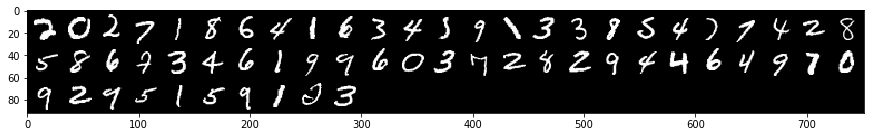

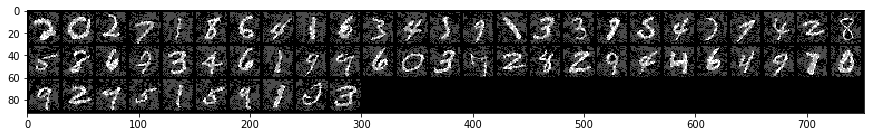

tensor([7, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 1, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2,
        8, 5, 8, 6, 9, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9,
        7, 0, 9, 2, 7, 5, 1, 5, 9, 1, 2, 3])


In [16]:
training_data_iter = iter(training_data)
b1 = next(training_data_iter)
b1 = next(training_data_iter)
b1 = next(training_data_iter)
a,b,c = b1

print(len(a))
print(len(b))
print(len(c))

show_batch(a)
show_batch(b)
print(c)

In [17]:
def train_model(model, train_data):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    n_epochs = 10
    model.train()
    
    model.to(device)
    
    print("training ...")
    for epoch in range(n_epochs):
        for batch in train_data:
            batch_images, adv_images, batch_labels = batch

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            adv_images = adv_images.to(device)
            
            batch_output = model(batch_images)
            
            latent_1 = model.encode(batch_images)
            latent_2 = model.encode(adv_images)
            
            down_stream_loss = criterion(batch_output, batch_labels)
            representation_loss = MMD_Loss(latent_1, latent_2)
            
            total_loss = down_stream_loss + 100*representation_loss
            
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            print("The classification loss after processing this batch is: ", down_stream_loss.item())
            print("The representation loss after processing this batch is: ", representation_loss.item())
            print("")
            
    print("Done training..")
    print("=*="*20)
    return model



In [18]:

def MMD_Loss(x, y):
    
    alpha =1
    B=b_size

    x = x.view(x.size(0), x.size(1) * 1)
    y = y.view(y.size(0), y.size(1) * 1)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    beta = (1./(B*(B-1)))
    gamma = (2./(B*B)) 

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [19]:
modelMM = NeuralModel()
model = train_model(modelMM, training_data)

training ...
The classification loss after processing this batch is:  2.30633807182312
The representation loss after processing this batch is:  0.03597879409790039

The classification loss after processing this batch is:  2.339465856552124
The representation loss after processing this batch is:  0.032785892486572266

The classification loss after processing this batch is:  2.3406877517700195
The representation loss after processing this batch is:  0.030658245086669922

The classification loss after processing this batch is:  2.32474422454834
The representation loss after processing this batch is:  0.026526331901550293

The classification loss after processing this batch is:  2.3288662433624268
The representation loss after processing this batch is:  0.031468987464904785

The classification loss after processing this batch is:  2.33137845993042
The representation loss after processing this batch is:  0.030362963676452637

The classification loss after processing this batch is:  2.365344

The classification loss after processing this batch is:  2.117210626602173
The representation loss after processing this batch is:  0.011369109153747559

The classification loss after processing this batch is:  2.1304943561553955
The representation loss after processing this batch is:  0.01316782832145691

The classification loss after processing this batch is:  2.1801860332489014
The representation loss after processing this batch is:  0.013217777013778687

The classification loss after processing this batch is:  2.126214027404785
The representation loss after processing this batch is:  0.01138317584991455

The classification loss after processing this batch is:  2.117854118347168
The representation loss after processing this batch is:  0.010838627815246582

The classification loss after processing this batch is:  2.1322505474090576
The representation loss after processing this batch is:  0.011089980602264404

The classification loss after processing this batch is:  2.168306827545166


The classification loss after processing this batch is:  1.9878733158111572
The representation loss after processing this batch is:  0.007864400744438171

The classification loss after processing this batch is:  1.9259285926818848
The representation loss after processing this batch is:  0.007792085409164429

The classification loss after processing this batch is:  1.9253575801849365
The representation loss after processing this batch is:  0.0070341527462005615

The classification loss after processing this batch is:  1.9822783470153809
The representation loss after processing this batch is:  0.008275911211967468

The classification loss after processing this batch is:  1.9796065092086792
The representation loss after processing this batch is:  0.0076579749584198

The classification loss after processing this batch is:  1.8200223445892334
The representation loss after processing this batch is:  0.007386267185211182

The classification loss after processing this batch is:  1.811927676200

The classification loss after processing this batch is:  1.4778211116790771
The representation loss after processing this batch is:  0.007263533771038055

The classification loss after processing this batch is:  1.8031286001205444
The representation loss after processing this batch is:  0.006485268473625183

The classification loss after processing this batch is:  1.6711746454238892
The representation loss after processing this batch is:  0.0070176273584365845

The classification loss after processing this batch is:  1.7177609205245972
The representation loss after processing this batch is:  0.006086036562919617

The classification loss after processing this batch is:  1.7124649286270142
The representation loss after processing this batch is:  0.005749933421611786

The classification loss after processing this batch is:  1.6732443571090698
The representation loss after processing this batch is:  0.006818369030952454

The classification loss after processing this batch is:  1.6216436624

The classification loss after processing this batch is:  1.3739407062530518
The representation loss after processing this batch is:  0.006046086549758911

The classification loss after processing this batch is:  1.2111951112747192
The representation loss after processing this batch is:  0.004762977361679077

The classification loss after processing this batch is:  1.1905438899993896
The representation loss after processing this batch is:  0.005802221596240997

The classification loss after processing this batch is:  1.1955208778381348
The representation loss after processing this batch is:  0.005600534379482269

The classification loss after processing this batch is:  1.129170536994934
The representation loss after processing this batch is:  0.005655229091644287

The classification loss after processing this batch is:  1.2585207223892212
The representation loss after processing this batch is:  0.006140612065792084

The classification loss after processing this batch is:  1.365591645240

The representation loss after processing this batch is:  0.005485787987709045

The classification loss after processing this batch is:  0.9476682543754578
The representation loss after processing this batch is:  0.00612892210483551

The classification loss after processing this batch is:  0.8281425833702087
The representation loss after processing this batch is:  0.005917340517044067

The classification loss after processing this batch is:  0.9434033632278442
The representation loss after processing this batch is:  0.005988799035549164

The classification loss after processing this batch is:  0.8612644672393799
The representation loss after processing this batch is:  0.004856124520301819

The classification loss after processing this batch is:  0.7991098165512085
The representation loss after processing this batch is:  0.006291583180427551

The classification loss after processing this batch is:  0.8912028074264526
The representation loss after processing this batch is:  0.007170833647

The classification loss after processing this batch is:  0.697551429271698
The representation loss after processing this batch is:  0.007944338023662567

The classification loss after processing this batch is:  0.7793151140213013
The representation loss after processing this batch is:  0.006173163652420044

The classification loss after processing this batch is:  0.7546444535255432
The representation loss after processing this batch is:  0.005929891020059586

The classification loss after processing this batch is:  0.7198747396469116
The representation loss after processing this batch is:  0.005457237362861633

The classification loss after processing this batch is:  0.6250513792037964
The representation loss after processing this batch is:  0.005712270736694336

The classification loss after processing this batch is:  0.7687021493911743
The representation loss after processing this batch is:  0.004873484373092651

The classification loss after processing this batch is:  0.740424275398

The classification loss after processing this batch is:  0.9146539568901062
The representation loss after processing this batch is:  0.005222603678703308

The classification loss after processing this batch is:  0.6995447874069214
The representation loss after processing this batch is:  0.00580471009016037

The classification loss after processing this batch is:  0.5291481018066406
The representation loss after processing this batch is:  0.005479961633682251

The classification loss after processing this batch is:  0.6638204455375671
The representation loss after processing this batch is:  0.005886424332857132

The classification loss after processing this batch is:  0.7104552388191223
The representation loss after processing this batch is:  0.006012178957462311

The classification loss after processing this batch is:  0.7333201169967651
The representation loss after processing this batch is:  0.0048302821815013885

The classification loss after processing this batch is:  0.83294230699

The classification loss after processing this batch is:  0.5169594287872314
The representation loss after processing this batch is:  0.004680365324020386

The classification loss after processing this batch is:  0.6756897568702698
The representation loss after processing this batch is:  0.004693042486906052

The classification loss after processing this batch is:  0.5018997192382812
The representation loss after processing this batch is:  0.004425276070833206

The classification loss after processing this batch is:  0.5921527743339539
The representation loss after processing this batch is:  0.004796437919139862

The classification loss after processing this batch is:  0.7309637069702148
The representation loss after processing this batch is:  0.004758436232805252

The classification loss after processing this batch is:  0.5693251490592957
The representation loss after processing this batch is:  0.004615291953086853

The classification loss after processing this batch is:  0.85155445337

The classification loss after processing this batch is:  0.5426982045173645
The representation loss after processing this batch is:  0.004638202488422394

The classification loss after processing this batch is:  0.33623746037483215
The representation loss after processing this batch is:  0.0049504488706588745

The classification loss after processing this batch is:  0.5204216837882996
The representation loss after processing this batch is:  0.004348907619714737

The classification loss after processing this batch is:  0.42484351992607117
The representation loss after processing this batch is:  0.005338624119758606

The classification loss after processing this batch is:  0.3591752350330353
The representation loss after processing this batch is:  0.004316404461860657

The classification loss after processing this batch is:  0.3778323829174042
The representation loss after processing this batch is:  0.004446081817150116

The classification loss after processing this batch is:  0.47545680

The classification loss after processing this batch is:  0.6222082376480103
The representation loss after processing this batch is:  0.004914984107017517

The classification loss after processing this batch is:  0.6430426836013794
The representation loss after processing this batch is:  0.00535767525434494

The classification loss after processing this batch is:  0.4149971604347229
The representation loss after processing this batch is:  0.004055570811033249

The classification loss after processing this batch is:  0.5620461702346802
The representation loss after processing this batch is:  0.003985077142715454

The classification loss after processing this batch is:  0.3402356803417206
The representation loss after processing this batch is:  0.004542626440525055

The classification loss after processing this batch is:  0.3307223916053772
The representation loss after processing this batch is:  0.004242047667503357

The classification loss after processing this batch is:  0.399443328380

The classification loss after processing this batch is:  0.5430710315704346
The representation loss after processing this batch is:  0.0039057880640029907

The classification loss after processing this batch is:  0.5559712052345276
The representation loss after processing this batch is:  0.0041638389229774475

The classification loss after processing this batch is:  0.6539608240127563
The representation loss after processing this batch is:  0.003906548023223877

The classification loss after processing this batch is:  0.43829458951950073
The representation loss after processing this batch is:  0.00491960346698761

The classification loss after processing this batch is:  0.5672507882118225
The representation loss after processing this batch is:  0.004580393433570862

The classification loss after processing this batch is:  0.42387136816978455
The representation loss after processing this batch is:  0.004272282123565674

The classification loss after processing this batch is:  0.38754525

The classification loss after processing this batch is:  0.3556356430053711
The representation loss after processing this batch is:  0.003982823342084885

The classification loss after processing this batch is:  0.4028100371360779
The representation loss after processing this batch is:  0.004666775465011597

The classification loss after processing this batch is:  0.26060089468955994
The representation loss after processing this batch is:  0.0036420784890651703

The classification loss after processing this batch is:  0.3168196380138397
The representation loss after processing this batch is:  0.004635483026504517

The classification loss after processing this batch is:  0.33350667357444763
The representation loss after processing this batch is:  0.005186699330806732

The classification loss after processing this batch is:  0.4640487730503082
The representation loss after processing this batch is:  0.004620164632797241

The classification loss after processing this batch is:  0.28320488

The classification loss after processing this batch is:  0.23296216130256653
The representation loss after processing this batch is:  0.0038847848773002625

The classification loss after processing this batch is:  0.3477749526500702
The representation loss after processing this batch is:  0.00454210489988327

The classification loss after processing this batch is:  0.3055764138698578
The representation loss after processing this batch is:  0.003651157021522522

The classification loss after processing this batch is:  0.5058057308197021
The representation loss after processing this batch is:  0.0033433251082897186

The classification loss after processing this batch is:  0.39890173077583313
The representation loss after processing this batch is:  0.004579618573188782

The classification loss after processing this batch is:  0.3670000731945038
The representation loss after processing this batch is:  0.00548534095287323

The classification loss after processing this batch is:  0.266840994

The classification loss after processing this batch is:  0.26923903822898865
The representation loss after processing this batch is:  0.003481917083263397

The classification loss after processing this batch is:  0.40670570731163025
The representation loss after processing this batch is:  0.0040700435638427734

The classification loss after processing this batch is:  0.40058279037475586
The representation loss after processing this batch is:  0.003781009465456009

The classification loss after processing this batch is:  0.4441238045692444
The representation loss after processing this batch is:  0.003821447491645813

The classification loss after processing this batch is:  0.3499308228492737
The representation loss after processing this batch is:  0.0043133459985256195

The classification loss after processing this batch is:  0.4044044613838196
The representation loss after processing this batch is:  0.004698228091001511

The classification loss after processing this batch is:  0.269843

The classification loss after processing this batch is:  0.2924303710460663
The representation loss after processing this batch is:  0.004931427538394928

The classification loss after processing this batch is:  0.3548497259616852
The representation loss after processing this batch is:  0.004218339920043945

The classification loss after processing this batch is:  0.3063424229621887
The representation loss after processing this batch is:  0.004599928855895996

The classification loss after processing this batch is:  0.4547230303287506
The representation loss after processing this batch is:  0.004399016499519348

The classification loss after processing this batch is:  0.30752792954444885
The representation loss after processing this batch is:  0.0036793500185012817

The classification loss after processing this batch is:  0.3513754904270172
The representation loss after processing this batch is:  0.0038115717470645905

The classification loss after processing this batch is:  0.58620303

The classification loss after processing this batch is:  0.2361430823802948
The representation loss after processing this batch is:  0.00470917671918869

The classification loss after processing this batch is:  0.3252646028995514
The representation loss after processing this batch is:  0.005777508020401001

The classification loss after processing this batch is:  0.18932898342609406
The representation loss after processing this batch is:  0.004259705543518066

The classification loss after processing this batch is:  0.38125142455101013
The representation loss after processing this batch is:  0.005609676241874695

The classification loss after processing this batch is:  0.3206542730331421
The representation loss after processing this batch is:  0.004189983010292053

The classification loss after processing this batch is:  0.3238731324672699
The representation loss after processing this batch is:  0.003281891345977783

The classification loss after processing this batch is:  0.4204339981

The classification loss after processing this batch is:  0.26037314534187317
The representation loss after processing this batch is:  0.003936924040317535

The classification loss after processing this batch is:  0.12574054300785065
The representation loss after processing this batch is:  0.004243314266204834

The classification loss after processing this batch is:  0.29454299807548523
The representation loss after processing this batch is:  0.0044998303055763245

The classification loss after processing this batch is:  0.3152174651622772
The representation loss after processing this batch is:  0.004256244748830795

The classification loss after processing this batch is:  0.3472883105278015
The representation loss after processing this batch is:  0.0039078183472156525

The classification loss after processing this batch is:  0.29459384083747864
The representation loss after processing this batch is:  0.0038834884762763977

The classification loss after processing this batch is:  0.2920

The classification loss after processing this batch is:  0.38354015350341797
The representation loss after processing this batch is:  0.003667633980512619

The classification loss after processing this batch is:  0.3152400851249695
The representation loss after processing this batch is:  0.0049083903431892395

The classification loss after processing this batch is:  0.2895349860191345
The representation loss after processing this batch is:  0.004068169742822647

The classification loss after processing this batch is:  0.2072213739156723
The representation loss after processing this batch is:  0.0033680610358715057

The classification loss after processing this batch is:  0.3815039396286011
The representation loss after processing this batch is:  0.0036351382732391357

The classification loss after processing this batch is:  0.2092307060956955
The representation loss after processing this batch is:  0.003990650177001953

The classification loss after processing this batch is:  0.2161006

The classification loss after processing this batch is:  0.32207757234573364
The representation loss after processing this batch is:  0.003845416009426117

The classification loss after processing this batch is:  0.36432090401649475
The representation loss after processing this batch is:  0.004337728023529053

The classification loss after processing this batch is:  0.39513930678367615
The representation loss after processing this batch is:  0.003682859241962433

The classification loss after processing this batch is:  0.3546411395072937
The representation loss after processing this batch is:  0.00414237380027771

The classification loss after processing this batch is:  0.19801300764083862
The representation loss after processing this batch is:  0.003637455403804779

The classification loss after processing this batch is:  0.23359133303165436
The representation loss after processing this batch is:  0.003329060971736908

The classification loss after processing this batch is:  0.4202262

The classification loss after processing this batch is:  0.3098735213279724
The representation loss after processing this batch is:  0.003390960395336151

The classification loss after processing this batch is:  0.21287666261196136
The representation loss after processing this batch is:  0.0045369938015937805

The classification loss after processing this batch is:  0.22606249153614044
The representation loss after processing this batch is:  0.004210077226161957

The classification loss after processing this batch is:  0.30811020731925964
The representation loss after processing this batch is:  0.0036801956593990326

The classification loss after processing this batch is:  0.25838151574134827
The representation loss after processing this batch is:  0.0039510577917099

The classification loss after processing this batch is:  0.4972422420978546
The representation loss after processing this batch is:  0.003976479172706604

The classification loss after processing this batch is:  0.2571962

The classification loss after processing this batch is:  0.25570210814476013
The representation loss after processing this batch is:  0.0037588104605674744

The classification loss after processing this batch is:  0.46344324946403503
The representation loss after processing this batch is:  0.00388249009847641

The classification loss after processing this batch is:  0.3463391661643982
The representation loss after processing this batch is:  0.004124559462070465

The classification loss after processing this batch is:  0.2435952126979828
The representation loss after processing this batch is:  0.003539830446243286

The classification loss after processing this batch is:  0.2127041220664978
The representation loss after processing this batch is:  0.003495398908853531

The classification loss after processing this batch is:  0.21381695568561554
The representation loss after processing this batch is:  0.0030876025557518005

The classification loss after processing this batch is:  0.1956133

The classification loss after processing this batch is:  0.23216110467910767
The representation loss after processing this batch is:  0.002942349761724472

The classification loss after processing this batch is:  0.2641088664531708
The representation loss after processing this batch is:  0.0033039897680282593

The classification loss after processing this batch is:  0.31238606572151184
The representation loss after processing this batch is:  0.0034352801740169525

The classification loss after processing this batch is:  0.2285662442445755
The representation loss after processing this batch is:  0.003710635006427765

The classification loss after processing this batch is:  0.16981008648872375
The representation loss after processing this batch is:  0.0030763596296310425

The classification loss after processing this batch is:  0.25503408908843994
The representation loss after processing this batch is:  0.003054201602935791

The classification loss after processing this batch is:  0.2872

The classification loss after processing this batch is:  0.3302837908267975
The representation loss after processing this batch is:  0.003916997462511063

The classification loss after processing this batch is:  0.27862077951431274
The representation loss after processing this batch is:  0.0034773387014865875

The classification loss after processing this batch is:  0.2163202315568924
The representation loss after processing this batch is:  0.003589421510696411

The classification loss after processing this batch is:  0.33041611313819885
The representation loss after processing this batch is:  0.003510408103466034

The classification loss after processing this batch is:  0.22351369261741638
The representation loss after processing this batch is:  0.0036437399685382843

The classification loss after processing this batch is:  0.2531587779521942
The representation loss after processing this batch is:  0.003041975200176239

The classification loss after processing this batch is:  0.272781

The classification loss after processing this batch is:  0.31288382411003113
The representation loss after processing this batch is:  0.003704659640789032

The classification loss after processing this batch is:  0.29497385025024414
The representation loss after processing this batch is:  0.0029894039034843445

The classification loss after processing this batch is:  0.17114776372909546
The representation loss after processing this batch is:  0.004007279872894287

The classification loss after processing this batch is:  0.29059484601020813
The representation loss after processing this batch is:  0.00333201140165329

The classification loss after processing this batch is:  0.208891361951828
The representation loss after processing this batch is:  0.0033504776656627655

The classification loss after processing this batch is:  0.2892637252807617
The representation loss after processing this batch is:  0.0034789331257343292

The classification loss after processing this batch is:  0.417612

The classification loss after processing this batch is:  0.20648640394210815
The representation loss after processing this batch is:  0.004080519080162048

The classification loss after processing this batch is:  0.19971159100532532
The representation loss after processing this batch is:  0.003260381519794464

The classification loss after processing this batch is:  0.17109426856040955
The representation loss after processing this batch is:  0.00344260036945343

The classification loss after processing this batch is:  0.2542474865913391
The representation loss after processing this batch is:  0.00290071964263916

The classification loss after processing this batch is:  0.24620892107486725
The representation loss after processing this batch is:  0.003176286816596985

The classification loss after processing this batch is:  0.31324055790901184
The representation loss after processing this batch is:  0.0036938712000846863

The classification loss after processing this batch is:  0.1906568

The classification loss after processing this batch is:  0.33595889806747437
The representation loss after processing this batch is:  0.00368407741189003

The classification loss after processing this batch is:  0.22045892477035522
The representation loss after processing this batch is:  0.003408830612897873

The classification loss after processing this batch is:  0.14352242648601532
The representation loss after processing this batch is:  0.0037645921111106873

The classification loss after processing this batch is:  0.21470597386360168
The representation loss after processing this batch is:  0.003385476768016815

The classification loss after processing this batch is:  0.21442630887031555
The representation loss after processing this batch is:  0.003458090126514435

The classification loss after processing this batch is:  0.14991943538188934
The representation loss after processing this batch is:  0.003166012465953827

The classification loss after processing this batch is:  0.10539

The classification loss after processing this batch is:  0.3629591763019562
The representation loss after processing this batch is:  0.003609016537666321

The classification loss after processing this batch is:  0.11229292303323746
The representation loss after processing this batch is:  0.0036823898553848267

The classification loss after processing this batch is:  0.18611058592796326
The representation loss after processing this batch is:  0.003607124090194702

The classification loss after processing this batch is:  0.24496930837631226
The representation loss after processing this batch is:  0.0029228627681732178

The classification loss after processing this batch is:  0.38125619292259216
The representation loss after processing this batch is:  0.0035621151328086853

The classification loss after processing this batch is:  0.1657858043909073
The representation loss after processing this batch is:  0.003182917833328247

The classification loss after processing this batch is:  0.2408

The classification loss after processing this batch is:  0.12837159633636475
The representation loss after processing this batch is:  0.003196343779563904

The classification loss after processing this batch is:  0.4197961091995239
The representation loss after processing this batch is:  0.0030889511108398438

The classification loss after processing this batch is:  0.21985338628292084
The representation loss after processing this batch is:  0.0027945153415203094

The classification loss after processing this batch is:  0.20728597044944763
The representation loss after processing this batch is:  0.0030588433146476746

The classification loss after processing this batch is:  0.3099066913127899
The representation loss after processing this batch is:  0.003745395690202713

The classification loss after processing this batch is:  0.2784474492073059
The representation loss after processing this batch is:  0.003527231514453888

The classification loss after processing this batch is:  0.12071

The classification loss after processing this batch is:  0.412854939699173
The representation loss after processing this batch is:  0.0032151155173778534

The classification loss after processing this batch is:  0.2542418837547302
The representation loss after processing this batch is:  0.002889402210712433

The classification loss after processing this batch is:  0.14784838259220123
The representation loss after processing this batch is:  0.003144197165966034

The classification loss after processing this batch is:  0.2711048126220703
The representation loss after processing this batch is:  0.0029400475323200226

The classification loss after processing this batch is:  0.24638350307941437
The representation loss after processing this batch is:  0.0029676631093025208

The classification loss after processing this batch is:  0.19721965491771698
The representation loss after processing this batch is:  0.0032083578407764435

The classification loss after processing this batch is:  0.14069

The classification loss after processing this batch is:  0.29745230078697205
The representation loss after processing this batch is:  0.002908967435359955

The classification loss after processing this batch is:  0.17347083985805511
The representation loss after processing this batch is:  0.0037878043949604034

The classification loss after processing this batch is:  0.2561739981174469
The representation loss after processing this batch is:  0.004125960171222687

The classification loss after processing this batch is:  0.31019294261932373
The representation loss after processing this batch is:  0.004112660884857178

The classification loss after processing this batch is:  0.18979482352733612
The representation loss after processing this batch is:  0.0034365952014923096

The classification loss after processing this batch is:  0.21067164838314056
The representation loss after processing this batch is:  0.002792052924633026

The classification loss after processing this batch is:  0.1642

The classification loss after processing this batch is:  0.24754036962985992
The representation loss after processing this batch is:  0.003119315952062607

The classification loss after processing this batch is:  0.19615046679973602
The representation loss after processing this batch is:  0.0033827759325504303

The classification loss after processing this batch is:  0.18694782257080078
The representation loss after processing this batch is:  0.0030596479773521423

The classification loss after processing this batch is:  0.253030002117157
The representation loss after processing this batch is:  0.0034688562154769897

The classification loss after processing this batch is:  0.1539698988199234
The representation loss after processing this batch is:  0.003295205533504486

The classification loss after processing this batch is:  0.17868439853191376
The representation loss after processing this batch is:  0.003670237958431244

The classification loss after processing this batch is:  0.21644

The classification loss after processing this batch is:  0.1280640810728073
The representation loss after processing this batch is:  0.0032312944531440735

The classification loss after processing this batch is:  0.15632864832878113
The representation loss after processing this batch is:  0.003214441239833832

The classification loss after processing this batch is:  0.151136115193367
The representation loss after processing this batch is:  0.0035568922758102417

The classification loss after processing this batch is:  0.1550133228302002
The representation loss after processing this batch is:  0.003246508538722992

The classification loss after processing this batch is:  0.1771365851163864
The representation loss after processing this batch is:  0.0033205263316631317

The classification loss after processing this batch is:  0.24445849657058716
The representation loss after processing this batch is:  0.0036407113075256348

The classification loss after processing this batch is:  0.198062

The classification loss after processing this batch is:  0.1177956759929657
The representation loss after processing this batch is:  0.0032601431012153625

The classification loss after processing this batch is:  0.14473682641983032
The representation loss after processing this batch is:  0.0027296654880046844

The classification loss after processing this batch is:  0.28530070185661316
The representation loss after processing this batch is:  0.003232695162296295

The classification loss after processing this batch is:  0.3242259919643402
The representation loss after processing this batch is:  0.003140389919281006

The classification loss after processing this batch is:  0.286848247051239
The representation loss after processing this batch is:  0.0032406002283096313

The classification loss after processing this batch is:  0.3604196012020111
The representation loss after processing this batch is:  0.0032330378890037537

The classification loss after processing this batch is:  0.171678

The classification loss after processing this batch is:  0.15526120364665985
The representation loss after processing this batch is:  0.00326620414853096

The classification loss after processing this batch is:  0.4322362244129181
The representation loss after processing this batch is:  0.0035103484988212585

The classification loss after processing this batch is:  0.1694101244211197
The representation loss after processing this batch is:  0.0031077563762664795

The classification loss after processing this batch is:  0.31019002199172974
The representation loss after processing this batch is:  0.004098899662494659

The classification loss after processing this batch is:  0.17166917026042938
The representation loss after processing this batch is:  0.002912849187850952

The classification loss after processing this batch is:  0.18015989661216736
The representation loss after processing this batch is:  0.003016427159309387

The classification loss after processing this batch is:  0.188061

The classification loss after processing this batch is:  0.1678374856710434
The representation loss after processing this batch is:  0.0029510706663131714

The classification loss after processing this batch is:  0.1272321194410324
The representation loss after processing this batch is:  0.00317995622754097

The classification loss after processing this batch is:  0.1386800855398178
The representation loss after processing this batch is:  0.0027472898364067078

The classification loss after processing this batch is:  0.12433936446905136
The representation loss after processing this batch is:  0.0036515891551971436

The classification loss after processing this batch is:  0.1522982269525528
The representation loss after processing this batch is:  0.0027912408113479614

The classification loss after processing this batch is:  0.28891268372535706
The representation loss after processing this batch is:  0.002846173942089081

The classification loss after processing this batch is:  0.338088

The classification loss after processing this batch is:  0.16798926889896393
The representation loss after processing this batch is:  0.003094486892223358

The classification loss after processing this batch is:  0.12019108235836029
The representation loss after processing this batch is:  0.0028949305415153503

The classification loss after processing this batch is:  0.1854337602853775
The representation loss after processing this batch is:  0.002807512879371643

The classification loss after processing this batch is:  0.24074022471904755
The representation loss after processing this batch is:  0.002537459135055542

The classification loss after processing this batch is:  0.11602849513292313
The representation loss after processing this batch is:  0.002911895513534546

The classification loss after processing this batch is:  0.1759222149848938
The representation loss after processing this batch is:  0.0031053461134433746

The classification loss after processing this batch is:  0.17961

The classification loss after processing this batch is:  0.2639046907424927
The representation loss after processing this batch is:  0.002862103283405304

The classification loss after processing this batch is:  0.17626091837882996
The representation loss after processing this batch is:  0.003149077296257019

The classification loss after processing this batch is:  0.1996169239282608
The representation loss after processing this batch is:  0.0027157291769981384

The classification loss after processing this batch is:  0.20514602959156036
The representation loss after processing this batch is:  0.0031134262681007385

The classification loss after processing this batch is:  0.18890336155891418
The representation loss after processing this batch is:  0.002601839601993561

The classification loss after processing this batch is:  0.1663466989994049
The representation loss after processing this batch is:  0.0029982104897499084

The classification loss after processing this batch is:  0.17751

The classification loss after processing this batch is:  0.11914057284593582
The representation loss after processing this batch is:  0.0033585280179977417

The classification loss after processing this batch is:  0.2357778400182724
The representation loss after processing this batch is:  0.002889096736907959

The classification loss after processing this batch is:  0.13244707882404327
The representation loss after processing this batch is:  0.002842310816049576

The classification loss after processing this batch is:  0.21566009521484375
The representation loss after processing this batch is:  0.00291626900434494

The classification loss after processing this batch is:  0.32318392395973206
The representation loss after processing this batch is:  0.0031280890107154846

The classification loss after processing this batch is:  0.16848841309547424
The representation loss after processing this batch is:  0.002887248992919922

The classification loss after processing this batch is:  0.23589

The representation loss after processing this batch is:  0.0029001235961914062

The classification loss after processing this batch is:  0.20514236390590668
The representation loss after processing this batch is:  0.0025283917784690857

The classification loss after processing this batch is:  0.20362690091133118
The representation loss after processing this batch is:  0.0027660951018333435

The classification loss after processing this batch is:  0.2456287294626236
The representation loss after processing this batch is:  0.003224208950996399

The classification loss after processing this batch is:  0.14888018369674683
The representation loss after processing this batch is:  0.0026924312114715576

The classification loss after processing this batch is:  0.3465636074542999
The representation loss after processing this batch is:  0.0022570043802261353

The classification loss after processing this batch is:  0.1632220596075058
The representation loss after processing this batch is:  0.002

The classification loss after processing this batch is:  0.10071178525686264
The representation loss after processing this batch is:  0.0028281882405281067

The classification loss after processing this batch is:  0.07158636301755905
The representation loss after processing this batch is:  0.002840481698513031

The classification loss after processing this batch is:  0.22111953794956207
The representation loss after processing this batch is:  0.002832546830177307

The classification loss after processing this batch is:  0.242617666721344
The representation loss after processing this batch is:  0.0026419535279273987

The classification loss after processing this batch is:  0.1530599594116211
The representation loss after processing this batch is:  0.0031074099242687225

The classification loss after processing this batch is:  0.2730456590652466
The representation loss after processing this batch is:  0.00284595787525177

The classification loss after processing this batch is:  0.2889468

The classification loss after processing this batch is:  0.16294756531715393
The representation loss after processing this batch is:  0.0024992190301418304

The classification loss after processing this batch is:  0.09015101939439774
The representation loss after processing this batch is:  0.0029824823141098022

The classification loss after processing this batch is:  0.06946033984422684
The representation loss after processing this batch is:  0.002746090292930603

The classification loss after processing this batch is:  0.16432644426822662
The representation loss after processing this batch is:  0.003488674759864807

The classification loss after processing this batch is:  0.13711626827716827
The representation loss after processing this batch is:  0.003637559711933136

The classification loss after processing this batch is:  0.08784699440002441
The representation loss after processing this batch is:  0.0030104145407676697

The classification loss after processing this batch is:  0.10

The classification loss after processing this batch is:  0.08580590784549713
The representation loss after processing this batch is:  0.0028788968920707703

The classification loss after processing this batch is:  0.2560877203941345
The representation loss after processing this batch is:  0.003467053174972534

The classification loss after processing this batch is:  0.18200190365314484
The representation loss after processing this batch is:  0.002975042909383774

The classification loss after processing this batch is:  0.3205004930496216
The representation loss after processing this batch is:  0.0026719197630882263

The classification loss after processing this batch is:  0.11980835348367691
The representation loss after processing this batch is:  0.0025552622973918915

The classification loss after processing this batch is:  0.09408973902463913
The representation loss after processing this batch is:  0.0028565898537635803

The classification loss after processing this batch is:  0.116

The classification loss after processing this batch is:  0.10387597978115082
The representation loss after processing this batch is:  0.0025678128004074097

The classification loss after processing this batch is:  0.12813805043697357
The representation loss after processing this batch is:  0.00247153639793396

The classification loss after processing this batch is:  0.18796738982200623
The representation loss after processing this batch is:  0.0026293769478797913

The classification loss after processing this batch is:  0.16672039031982422
The representation loss after processing this batch is:  0.0031579509377479553

The classification loss after processing this batch is:  0.2247466742992401
The representation loss after processing this batch is:  0.002814117819070816

The classification loss after processing this batch is:  0.2692706882953644
The representation loss after processing this batch is:  0.002915196120738983

The classification loss after processing this batch is:  0.22257

The classification loss after processing this batch is:  0.10011851787567139
The representation loss after processing this batch is:  0.0026046037673950195

The classification loss after processing this batch is:  0.06247192248702049
The representation loss after processing this batch is:  0.0029904544353485107

The classification loss after processing this batch is:  0.0860961303114891
The representation loss after processing this batch is:  0.002948448061943054

The classification loss after processing this batch is:  0.11621157079935074
The representation loss after processing this batch is:  0.0027533285319805145

The classification loss after processing this batch is:  0.1549314558506012
The representation loss after processing this batch is:  0.002453848719596863

The classification loss after processing this batch is:  0.13735456764698029
The representation loss after processing this batch is:  0.0028859004378318787

The classification loss after processing this batch is:  0.179

The classification loss after processing this batch is:  0.16520293056964874
The representation loss after processing this batch is:  0.0029378384351730347

The classification loss after processing this batch is:  0.18386904895305634
The representation loss after processing this batch is:  0.0026886537671089172

The classification loss after processing this batch is:  0.16317196190357208
The representation loss after processing this batch is:  0.0030012354254722595

The classification loss after processing this batch is:  0.27552270889282227
The representation loss after processing this batch is:  0.002686426043510437

The classification loss after processing this batch is:  0.3198952376842499
The representation loss after processing this batch is:  0.002793446183204651

The classification loss after processing this batch is:  0.11102040857076645
The representation loss after processing this batch is:  0.0027009136974811554

The classification loss after processing this batch is:  0.14

The classification loss after processing this batch is:  0.15818378329277039
The representation loss after processing this batch is:  0.003219813108444214

The classification loss after processing this batch is:  0.16386063396930695
The representation loss after processing this batch is:  0.002820335328578949

The classification loss after processing this batch is:  0.18010219931602478
The representation loss after processing this batch is:  0.0033781975507736206

The classification loss after processing this batch is:  0.10153593122959137
The representation loss after processing this batch is:  0.0027260780334472656

The classification loss after processing this batch is:  0.11160895228385925
The representation loss after processing this batch is:  0.002654626965522766

The classification loss after processing this batch is:  0.11025109887123108
The representation loss after processing this batch is:  0.0032151788473129272

The classification loss after processing this batch is:  0.14

The classification loss after processing this batch is:  0.21212543547153473
The representation loss after processing this batch is:  0.002565711736679077

The classification loss after processing this batch is:  0.13237303495407104
The representation loss after processing this batch is:  0.0023789331316947937

The classification loss after processing this batch is:  0.12965735793113708
The representation loss after processing this batch is:  0.002952978014945984

The classification loss after processing this batch is:  0.10547458380460739
The representation loss after processing this batch is:  0.0027666985988616943

The classification loss after processing this batch is:  0.1404837965965271
The representation loss after processing this batch is:  0.0026813149452209473

The classification loss after processing this batch is:  0.19259004294872284
The representation loss after processing this batch is:  0.0025436803698539734

The classification loss after processing this batch is:  0.13

The classification loss after processing this batch is:  0.16425567865371704
The representation loss after processing this batch is:  0.0029761455953121185

The classification loss after processing this batch is:  0.24412943422794342
The representation loss after processing this batch is:  0.0028030872344970703

The classification loss after processing this batch is:  0.19597110152244568
The representation loss after processing this batch is:  0.00321882963180542

The classification loss after processing this batch is:  0.1876547783613205
The representation loss after processing this batch is:  0.003275640308856964

The classification loss after processing this batch is:  0.16906806826591492
The representation loss after processing this batch is:  0.0029988735914230347

The classification loss after processing this batch is:  0.060389187186956406
The representation loss after processing this batch is:  0.0029793530702590942

The classification loss after processing this batch is:  0.16

The classification loss after processing this batch is:  0.1650822013616562
The representation loss after processing this batch is:  0.0026749297976493835

The classification loss after processing this batch is:  0.1460505872964859
The representation loss after processing this batch is:  0.00266261026263237

The classification loss after processing this batch is:  0.12337760627269745
The representation loss after processing this batch is:  0.0029163621366024017

The classification loss after processing this batch is:  0.13528801500797272
The representation loss after processing this batch is:  0.0026632435619831085

The classification loss after processing this batch is:  0.2468244880437851
The representation loss after processing this batch is:  0.003035884350538254

The classification loss after processing this batch is:  0.16266052424907684
The representation loss after processing this batch is:  0.0024481453001499176

The classification loss after processing this batch is:  0.31745

The classification loss after processing this batch is:  0.07736856490373611
The representation loss after processing this batch is:  0.003046199679374695

The classification loss after processing this batch is:  0.1164945438504219
The representation loss after processing this batch is:  0.003361999988555908

The classification loss after processing this batch is:  0.11783938109874725
The representation loss after processing this batch is:  0.0029289312660694122

The classification loss after processing this batch is:  0.13377881050109863
The representation loss after processing this batch is:  0.002897653728723526

The classification loss after processing this batch is:  0.17180758714675903
The representation loss after processing this batch is:  0.003001488745212555

The classification loss after processing this batch is:  0.13614943623542786
The representation loss after processing this batch is:  0.0029385611414909363

The classification loss after processing this batch is:  0.1815

The classification loss after processing this batch is:  0.08439609408378601
The representation loss after processing this batch is:  0.002880997955799103

The classification loss after processing this batch is:  0.07794753462076187
The representation loss after processing this batch is:  0.002847563475370407

The classification loss after processing this batch is:  0.13772700726985931
The representation loss after processing this batch is:  0.0025320835411548615

The classification loss after processing this batch is:  0.19592441618442535
The representation loss after processing this batch is:  0.0026543810963630676

The classification loss after processing this batch is:  0.06235591694712639
The representation loss after processing this batch is:  0.0025704801082611084

The classification loss after processing this batch is:  0.08989714086055756
The representation loss after processing this batch is:  0.002552565187215805

The classification loss after processing this batch is:  0.21

The classification loss after processing this batch is:  0.12037577480077744
The representation loss after processing this batch is:  0.002599462866783142

The classification loss after processing this batch is:  0.11156247556209564
The representation loss after processing this batch is:  0.002786301076412201

The classification loss after processing this batch is:  0.11395183205604553
The representation loss after processing this batch is:  0.0026304051280021667

The classification loss after processing this batch is:  0.08254579454660416
The representation loss after processing this batch is:  0.0027648359537124634

The classification loss after processing this batch is:  0.06431550532579422
The representation loss after processing this batch is:  0.0025140270590782166

The classification loss after processing this batch is:  0.148210808634758
The representation loss after processing this batch is:  0.003004923462867737

The classification loss after processing this batch is:  0.0676

The classification loss after processing this batch is:  0.1508595198392868
The representation loss after processing this batch is:  0.0027527734637260437

The classification loss after processing this batch is:  0.09906218945980072
The representation loss after processing this batch is:  0.0027801617980003357

The classification loss after processing this batch is:  0.1917051523923874
The representation loss after processing this batch is:  0.002607487142086029

The classification loss after processing this batch is:  0.24021528661251068
The representation loss after processing this batch is:  0.0029899775981903076

The classification loss after processing this batch is:  0.1999632567167282
The representation loss after processing this batch is:  0.0028009451925754547

The classification loss after processing this batch is:  0.1478297859430313
The representation loss after processing this batch is:  0.0029653646051883698

The classification loss after processing this batch is:  0.1241

The classification loss after processing this batch is:  0.19830824434757233
The representation loss after processing this batch is:  0.0027770623564720154

The classification loss after processing this batch is:  0.10815612226724625
The representation loss after processing this batch is:  0.002839617431163788

The classification loss after processing this batch is:  0.08362244814634323
The representation loss after processing this batch is:  0.002949364483356476

The classification loss after processing this batch is:  0.10737760365009308
The representation loss after processing this batch is:  0.002333085983991623

The classification loss after processing this batch is:  0.08507803827524185
The representation loss after processing this batch is:  0.002885490655899048

The classification loss after processing this batch is:  0.043427761644124985
The representation loss after processing this batch is:  0.0031571760773658752

The classification loss after processing this batch is:  0.12

The classification loss after processing this batch is:  0.24452632665634155
The representation loss after processing this batch is:  0.0024282485246658325

The classification loss after processing this batch is:  0.2381618767976761
The representation loss after processing this batch is:  0.0028922930359840393

The classification loss after processing this batch is:  0.19846111536026
The representation loss after processing this batch is:  0.002310246229171753

The classification loss after processing this batch is:  0.16541044414043427
The representation loss after processing this batch is:  0.0030032694339752197

The classification loss after processing this batch is:  0.21648000180721283
The representation loss after processing this batch is:  0.0024552755057811737

The classification loss after processing this batch is:  0.10823190212249756
The representation loss after processing this batch is:  0.003279447555541992

The classification loss after processing this batch is:  0.10488

The classification loss after processing this batch is:  0.09157559275627136
The representation loss after processing this batch is:  0.002586372196674347

The classification loss after processing this batch is:  0.08540328592061996
The representation loss after processing this batch is:  0.0030014514923095703

The classification loss after processing this batch is:  0.16115345060825348
The representation loss after processing this batch is:  0.002640385180711746

The classification loss after processing this batch is:  0.09266389161348343
The representation loss after processing this batch is:  0.003112509846687317

The classification loss after processing this batch is:  0.10423443466424942
The representation loss after processing this batch is:  0.002435624599456787

The classification loss after processing this batch is:  0.05167084187269211
The representation loss after processing this batch is:  0.002709232270717621

The classification loss after processing this batch is:  0.0683

The classification loss after processing this batch is:  0.10854797810316086
The representation loss after processing this batch is:  0.002654634416103363

The classification loss after processing this batch is:  0.2662625014781952
The representation loss after processing this batch is:  0.0026535093784332275

The classification loss after processing this batch is:  0.2714892029762268
The representation loss after processing this batch is:  0.002573050558567047

The classification loss after processing this batch is:  0.11124084889888763
The representation loss after processing this batch is:  0.002838931977748871

The classification loss after processing this batch is:  0.12940089404582977
The representation loss after processing this batch is:  0.0028567835688591003

The classification loss after processing this batch is:  0.15984627604484558
The representation loss after processing this batch is:  0.0024377554655075073

The classification loss after processing this batch is:  0.0689

The representation loss after processing this batch is:  0.002740524709224701

The classification loss after processing this batch is:  0.11614135652780533
The representation loss after processing this batch is:  0.002628698945045471

The classification loss after processing this batch is:  0.10131663829088211
The representation loss after processing this batch is:  0.0025588199496269226

The classification loss after processing this batch is:  0.049655117094516754
The representation loss after processing this batch is:  0.002609550952911377

The classification loss after processing this batch is:  0.06332697719335556
The representation loss after processing this batch is:  0.002800416201353073

The classification loss after processing this batch is:  0.10715209692716599
The representation loss after processing this batch is:  0.0023788996040821075

The classification loss after processing this batch is:  0.1557280570268631
The representation loss after processing this batch is:  0.002

The classification loss after processing this batch is:  0.21715082228183746
The representation loss after processing this batch is:  0.00299198180437088

The classification loss after processing this batch is:  0.266963928937912
The representation loss after processing this batch is:  0.0031706392765045166

The classification loss after processing this batch is:  0.13729919493198395
The representation loss after processing this batch is:  0.0031227320432662964

The classification loss after processing this batch is:  0.1701558232307434
The representation loss after processing this batch is:  0.002925671637058258

The classification loss after processing this batch is:  0.15381470322608948
The representation loss after processing this batch is:  0.003230758011341095

The classification loss after processing this batch is:  0.08987811952829361
The representation loss after processing this batch is:  0.0027736425399780273

The classification loss after processing this batch is:  0.218065

The classification loss after processing this batch is:  0.07087216526269913
The representation loss after processing this batch is:  0.002730816602706909

The classification loss after processing this batch is:  0.16384004056453705
The representation loss after processing this batch is:  0.0025636032223701477

The classification loss after processing this batch is:  0.10659802705049515
The representation loss after processing this batch is:  0.002324730157852173

The classification loss after processing this batch is:  0.1431688815355301
The representation loss after processing this batch is:  0.0026483237743377686

The classification loss after processing this batch is:  0.07039868831634521
The representation loss after processing this batch is:  0.002920083701610565

The classification loss after processing this batch is:  0.18147630989551544
The representation loss after processing this batch is:  0.0025619827210903168

The classification loss after processing this batch is:  0.156

The classification loss after processing this batch is:  0.11112675815820694
The representation loss after processing this batch is:  0.002520732581615448

The classification loss after processing this batch is:  0.20239537954330444
The representation loss after processing this batch is:  0.002799421548843384

The classification loss after processing this batch is:  0.058138009160757065
The representation loss after processing this batch is:  0.0032053142786026

The classification loss after processing this batch is:  0.08935552090406418
The representation loss after processing this batch is:  0.002525482326745987

The classification loss after processing this batch is:  0.17013797163963318
The representation loss after processing this batch is:  0.002781391143798828

The classification loss after processing this batch is:  0.14408062398433685
The representation loss after processing this batch is:  0.0027105845510959625

The classification loss after processing this batch is:  0.16787

The classification loss after processing this batch is:  0.22387509047985077
The representation loss after processing this batch is:  0.0026813820004463196

The classification loss after processing this batch is:  0.12203562259674072
The representation loss after processing this batch is:  0.0022532716393470764

The classification loss after processing this batch is:  0.1043098121881485
The representation loss after processing this batch is:  0.00280563160777092

The classification loss after processing this batch is:  0.10295386612415314
The representation loss after processing this batch is:  0.002485603094100952

The classification loss after processing this batch is:  0.09760645031929016
The representation loss after processing this batch is:  0.0026530921459198

The classification loss after processing this batch is:  0.11958550661802292
The representation loss after processing this batch is:  0.0027961507439613342

The classification loss after processing this batch is:  0.060772

The classification loss after processing this batch is:  0.14429457485675812
The representation loss after processing this batch is:  0.002524442970752716

The classification loss after processing this batch is:  0.18635018169879913
The representation loss after processing this batch is:  0.002783045172691345

The classification loss after processing this batch is:  0.14846055209636688
The representation loss after processing this batch is:  0.0024517178535461426

The classification loss after processing this batch is:  0.19312109053134918
The representation loss after processing this batch is:  0.0023770034313201904

The classification loss after processing this batch is:  0.1333431750535965
The representation loss after processing this batch is:  0.00255575031042099

The classification loss after processing this batch is:  0.18322314321994781
The representation loss after processing this batch is:  0.002585098147392273

The classification loss after processing this batch is:  0.20709

The classification loss after processing this batch is:  0.06346867233514786
The representation loss after processing this batch is:  0.0026325471699237823

The classification loss after processing this batch is:  0.10782972723245621
The representation loss after processing this batch is:  0.002555079758167267

The classification loss after processing this batch is:  0.12328552454710007
The representation loss after processing this batch is:  0.0027778595685958862

The classification loss after processing this batch is:  0.10521713644266129
The representation loss after processing this batch is:  0.002547331154346466

The classification loss after processing this batch is:  0.12286494672298431
The representation loss after processing this batch is:  0.0026439428329467773

The classification loss after processing this batch is:  0.1255297064781189
The representation loss after processing this batch is:  0.0031970813870429993

The classification loss after processing this batch is:  0.13

The classification loss after processing this batch is:  0.20118919014930725
The representation loss after processing this batch is:  0.0024108774960041046

The classification loss after processing this batch is:  0.07130619883537292
The representation loss after processing this batch is:  0.00295354425907135

The classification loss after processing this batch is:  0.042210932821035385
The representation loss after processing this batch is:  0.002445630729198456

The classification loss after processing this batch is:  0.06204860284924507
The representation loss after processing this batch is:  0.002422928810119629

The classification loss after processing this batch is:  0.16381222009658813
The representation loss after processing this batch is:  0.0031344667077064514

The classification loss after processing this batch is:  0.16330856084823608
The representation loss after processing this batch is:  0.0028349310159683228

The classification loss after processing this batch is:  0.08

The classification loss after processing this batch is:  0.20120741426944733
The representation loss after processing this batch is:  0.002563178539276123

The classification loss after processing this batch is:  0.24103416502475739
The representation loss after processing this batch is:  0.0023734718561172485

The classification loss after processing this batch is:  0.1435641646385193
The representation loss after processing this batch is:  0.002376370131969452

The classification loss after processing this batch is:  0.05404987558722496
The representation loss after processing this batch is:  0.0027496516704559326

The classification loss after processing this batch is:  0.07044745236635208
The representation loss after processing this batch is:  0.002971276640892029

The classification loss after processing this batch is:  0.06302950531244278
The representation loss after processing this batch is:  0.003031298518180847

The classification loss after processing this batch is:  0.0897

The representation loss after processing this batch is:  0.002373073250055313

The classification loss after processing this batch is:  0.13241489231586456
The representation loss after processing this batch is:  0.0024102479219436646

The classification loss after processing this batch is:  0.035179223865270615
The representation loss after processing this batch is:  0.002661503851413727

The classification loss after processing this batch is:  0.11715690046548843
The representation loss after processing this batch is:  0.002546742558479309

The classification loss after processing this batch is:  0.23710645735263824
The representation loss after processing this batch is:  0.002841208130121231

The classification loss after processing this batch is:  0.29084283113479614
The representation loss after processing this batch is:  0.0028121918439865112

The classification loss after processing this batch is:  0.2519196569919586
The representation loss after processing this batch is:  0.002

The classification loss after processing this batch is:  0.08273757994174957
The representation loss after processing this batch is:  0.0026462674140930176

The classification loss after processing this batch is:  0.09447219222784042
The representation loss after processing this batch is:  0.002434220165014267

The classification loss after processing this batch is:  0.15255050361156464
The representation loss after processing this batch is:  0.0025911852717399597

The classification loss after processing this batch is:  0.044232748448848724
The representation loss after processing this batch is:  0.0025136545300483704

The classification loss after processing this batch is:  0.16915683448314667
The representation loss after processing this batch is:  0.002710960805416107

The classification loss after processing this batch is:  0.09898258745670319
The representation loss after processing this batch is:  0.002357892692089081

The classification loss after processing this batch is:  0.2

The classification loss after processing this batch is:  0.055411335080862045
The representation loss after processing this batch is:  0.0026764050126075745

The classification loss after processing this batch is:  0.08532442897558212
The representation loss after processing this batch is:  0.0022949501872062683

The classification loss after processing this batch is:  0.18073712289333344
The representation loss after processing this batch is:  0.0024335309863090515

The classification loss after processing this batch is:  0.08828959614038467
The representation loss after processing this batch is:  0.0029570162296295166

The classification loss after processing this batch is:  0.05899260193109512
The representation loss after processing this batch is:  0.002520039677619934

The classification loss after processing this batch is:  0.034118108451366425
The representation loss after processing this batch is:  0.003152221441268921

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.08704280108213425
The representation loss after processing this batch is:  0.0023685209453105927

The classification loss after processing this batch is:  0.08072587847709656
The representation loss after processing this batch is:  0.002748429775238037

The classification loss after processing this batch is:  0.07773125171661377
The representation loss after processing this batch is:  0.0025848671793937683

The classification loss after processing this batch is:  0.18419910967350006
The representation loss after processing this batch is:  0.002857029438018799

The classification loss after processing this batch is:  0.0947633609175682
The representation loss after processing this batch is:  0.002497442066669464

The classification loss after processing this batch is:  0.08042499423027039
The representation loss after processing this batch is:  0.0024290643632411957

The classification loss after processing this batch is:  0.134

The classification loss after processing this batch is:  0.05846729129552841
The representation loss after processing this batch is:  0.0027368739247322083

The classification loss after processing this batch is:  0.11958661675453186
The representation loss after processing this batch is:  0.0023561418056488037

The classification loss after processing this batch is:  0.0782320648431778
The representation loss after processing this batch is:  0.003212064504623413

The classification loss after processing this batch is:  0.09195657819509506
The representation loss after processing this batch is:  0.002862546592950821

The classification loss after processing this batch is:  0.2336483597755432
The representation loss after processing this batch is:  0.0035632625222206116

The classification loss after processing this batch is:  0.22671197354793549
The representation loss after processing this batch is:  0.002254076302051544

The classification loss after processing this batch is:  0.1141

The classification loss after processing this batch is:  0.06911031901836395
The representation loss after processing this batch is:  0.002505481243133545

The classification loss after processing this batch is:  0.06193969026207924
The representation loss after processing this batch is:  0.0023165233433246613

The classification loss after processing this batch is:  0.26043620705604553
The representation loss after processing this batch is:  0.0023292601108551025

The classification loss after processing this batch is:  0.10448034852743149
The representation loss after processing this batch is:  0.0027061328291893005

The classification loss after processing this batch is:  0.054626815021038055
The representation loss after processing this batch is:  0.002629324793815613

The classification loss after processing this batch is:  0.12686681747436523
The representation loss after processing this batch is:  0.00264856219291687

The classification loss after processing this batch is:  0.09

The classification loss after processing this batch is:  0.054620131850242615
The representation loss after processing this batch is:  0.002423606812953949

The classification loss after processing this batch is:  0.09817290306091309
The representation loss after processing this batch is:  0.0023324787616729736

The classification loss after processing this batch is:  0.12090830504894257
The representation loss after processing this batch is:  0.0028421208262443542

The classification loss after processing this batch is:  0.1517450511455536
The representation loss after processing this batch is:  0.002336248755455017

The classification loss after processing this batch is:  0.09202774614095688
The representation loss after processing this batch is:  0.002465255558490753

The classification loss after processing this batch is:  0.09333683550357819
The representation loss after processing this batch is:  0.0023622438311576843

The classification loss after processing this batch is:  0.04

The classification loss after processing this batch is:  0.0988859087228775
The representation loss after processing this batch is:  0.0026052817702293396

The classification loss after processing this batch is:  0.12249650806188583
The representation loss after processing this batch is:  0.002827361226081848

The classification loss after processing this batch is:  0.0610235370695591
The representation loss after processing this batch is:  0.0025087296962738037

The classification loss after processing this batch is:  0.060418713837862015
The representation loss after processing this batch is:  0.002551831305027008

The classification loss after processing this batch is:  0.07284913212060928
The representation loss after processing this batch is:  0.0024091005325317383

The classification loss after processing this batch is:  0.16177740693092346
The representation loss after processing this batch is:  0.002594500780105591

The classification loss after processing this batch is:  0.137

The classification loss after processing this batch is:  0.10272030532360077
The representation loss after processing this batch is:  0.002333570271730423

The classification loss after processing this batch is:  0.06593824923038483
The representation loss after processing this batch is:  0.002598445862531662

The classification loss after processing this batch is:  0.11891207844018936
The representation loss after processing this batch is:  0.002201620489358902

The classification loss after processing this batch is:  0.09770932793617249
The representation loss after processing this batch is:  0.002657003700733185

The classification loss after processing this batch is:  0.1250290423631668
The representation loss after processing this batch is:  0.0025931671261787415

The classification loss after processing this batch is:  0.12287867069244385
The representation loss after processing this batch is:  0.0031226500868797302

The classification loss after processing this batch is:  0.0643

The representation loss after processing this batch is:  0.0025750398635864258

The classification loss after processing this batch is:  0.1052081435918808
The representation loss after processing this batch is:  0.002782389521598816

The classification loss after processing this batch is:  0.05184514448046684
The representation loss after processing this batch is:  0.0027601048350334167

The classification loss after processing this batch is:  0.12888029217720032
The representation loss after processing this batch is:  0.002345442771911621

The classification loss after processing this batch is:  0.14396348595619202
The representation loss after processing this batch is:  0.0022227726876735687

The classification loss after processing this batch is:  0.07706915587186813
The representation loss after processing this batch is:  0.0027123093605041504

The classification loss after processing this batch is:  0.15017063915729523
The representation loss after processing this batch is:  0.00

The classification loss after processing this batch is:  0.12078886479139328
The representation loss after processing this batch is:  0.0024785473942756653

The classification loss after processing this batch is:  0.15732938051223755
The representation loss after processing this batch is:  0.0024968013167381287

The classification loss after processing this batch is:  0.1925160139799118
The representation loss after processing this batch is:  0.0026963576674461365

The classification loss after processing this batch is:  0.23480266332626343
The representation loss after processing this batch is:  0.0024445131421089172

The classification loss after processing this batch is:  0.14409373700618744
The representation loss after processing this batch is:  0.002501383423805237

The classification loss after processing this batch is:  0.05060390755534172
The representation loss after processing this batch is:  0.0030877143144607544

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.1117284968495369
The representation loss after processing this batch is:  0.0025846511125564575

The classification loss after processing this batch is:  0.1128433421254158
The representation loss after processing this batch is:  0.0030082762241363525

The classification loss after processing this batch is:  0.12633059918880463
The representation loss after processing this batch is:  0.002833828330039978

The classification loss after processing this batch is:  0.16560839116573334
The representation loss after processing this batch is:  0.0024963319301605225

The classification loss after processing this batch is:  0.15252819657325745
The representation loss after processing this batch is:  0.0025062263011932373

The classification loss after processing this batch is:  0.14923371374607086
The representation loss after processing this batch is:  0.0023428238928318024

The classification loss after processing this batch is:  0.06

The classification loss after processing this batch is:  0.04974151775240898
The representation loss after processing this batch is:  0.0023793652653694153

The classification loss after processing this batch is:  0.1449935883283615
The representation loss after processing this batch is:  0.003039538860321045

The classification loss after processing this batch is:  0.15367881953716278
The representation loss after processing this batch is:  0.0026565417647361755

The classification loss after processing this batch is:  0.0760003849864006
The representation loss after processing this batch is:  0.003189265727996826

The classification loss after processing this batch is:  0.09438380599021912
The representation loss after processing this batch is:  0.002302907407283783

The classification loss after processing this batch is:  0.06618455797433853
The representation loss after processing this batch is:  0.0026220008730888367

The classification loss after processing this batch is:  0.1344

The classification loss after processing this batch is:  0.04730930179357529
The representation loss after processing this batch is:  0.0027003400027751923

The classification loss after processing this batch is:  0.06381835043430328
The representation loss after processing this batch is:  0.0028172507882118225

The classification loss after processing this batch is:  0.0514884851872921
The representation loss after processing this batch is:  0.002935469150543213

The classification loss after processing this batch is:  0.07984548062086105
The representation loss after processing this batch is:  0.002767018973827362

The classification loss after processing this batch is:  0.09553644061088562
The representation loss after processing this batch is:  0.0021473579108715057

The classification loss after processing this batch is:  0.24881142377853394
The representation loss after processing this batch is:  0.0024845264852046967

The classification loss after processing this batch is:  0.17

The classification loss after processing this batch is:  0.02775021456182003
The representation loss after processing this batch is:  0.0025392770767211914

The classification loss after processing this batch is:  0.115827776491642
The representation loss after processing this batch is:  0.0024299100041389465

The classification loss after processing this batch is:  0.22025057673454285
The representation loss after processing this batch is:  0.002726387232542038

The classification loss after processing this batch is:  0.2644781768321991
The representation loss after processing this batch is:  0.00275372713804245

The classification loss after processing this batch is:  0.22608546912670135
The representation loss after processing this batch is:  0.0024195238947868347

The classification loss after processing this batch is:  0.1743190735578537
The representation loss after processing this batch is:  0.002226606011390686

The classification loss after processing this batch is:  0.0751756

The classification loss after processing this batch is:  0.08694979548454285
The representation loss after processing this batch is:  0.002402558922767639

The classification loss after processing this batch is:  0.13912071287631989
The representation loss after processing this batch is:  0.002513095736503601

The classification loss after processing this batch is:  0.03661177679896355
The representation loss after processing this batch is:  0.00245000422000885

The classification loss after processing this batch is:  0.15686260163784027
The representation loss after processing this batch is:  0.0026399269700050354

The classification loss after processing this batch is:  0.08833198994398117
The representation loss after processing this batch is:  0.002297930419445038

The classification loss after processing this batch is:  0.2106734663248062
The representation loss after processing this batch is:  0.0024959594011306763

The classification loss after processing this batch is:  0.14648

The classification loss after processing this batch is:  0.0791168063879013
The representation loss after processing this batch is:  0.0022829920053482056

The classification loss after processing this batch is:  0.17385229468345642
The representation loss after processing this batch is:  0.0024395324289798737

The classification loss after processing this batch is:  0.07959451526403427
The representation loss after processing this batch is:  0.0029642805457115173

The classification loss after processing this batch is:  0.052223410457372665
The representation loss after processing this batch is:  0.002477586269378662

The classification loss after processing this batch is:  0.027625195682048798
The representation loss after processing this batch is:  0.0031038224697113037

The classification loss after processing this batch is:  0.03464977443218231
The representation loss after processing this batch is:  0.0029081404209136963

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.14408622682094574
The representation loss after processing this batch is:  0.002408605068922043

The classification loss after processing this batch is:  0.06370007246732712
The representation loss after processing this batch is:  0.002819657325744629

The classification loss after processing this batch is:  0.08950839191675186
The representation loss after processing this batch is:  0.0022597089409828186

The classification loss after processing this batch is:  0.036354418843984604
The representation loss after processing this batch is:  0.0024959146976470947

The classification loss after processing this batch is:  0.05185015872120857
The representation loss after processing this batch is:  0.0027707554399967194

The classification loss after processing this batch is:  0.08015785366296768
The representation loss after processing this batch is:  0.0023418068885803223

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.2454151213169098
The representation loss after processing this batch is:  0.00261620432138443

The classification loss after processing this batch is:  0.245985209941864
The representation loss after processing this batch is:  0.002436131238937378

The classification loss after processing this batch is:  0.08190441876649857
The representation loss after processing this batch is:  0.0026681050658226013

The classification loss after processing this batch is:  0.10407961159944534
The representation loss after processing this batch is:  0.0026866719126701355

The classification loss after processing this batch is:  0.13601723313331604
The representation loss after processing this batch is:  0.0022482238709926605

The classification loss after processing this batch is:  0.04941628873348236
The representation loss after processing this batch is:  0.0025667771697044373

The classification loss after processing this batch is:  0.05264

The classification loss after processing this batch is:  0.08007009327411652
The representation loss after processing this batch is:  0.0025202110409736633

The classification loss after processing this batch is:  0.031987763941287994
The representation loss after processing this batch is:  0.0024177655577659607

The classification loss after processing this batch is:  0.04477660357952118
The representation loss after processing this batch is:  0.0026157647371292114

The classification loss after processing this batch is:  0.0846661627292633
The representation loss after processing this batch is:  0.0021411925554275513

The classification loss after processing this batch is:  0.11486224085092545
The representation loss after processing this batch is:  0.002327665686607361

The classification loss after processing this batch is:  0.07860999554395676
The representation loss after processing this batch is:  0.002678096294403076

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.10404892265796661
The representation loss after processing this batch is:  0.002844296395778656

The classification loss after processing this batch is:  0.15316656231880188
The representation loss after processing this batch is:  0.0027074813842773438

The classification loss after processing this batch is:  0.1479613333940506
The representation loss after processing this batch is:  0.003115728497505188

The classification loss after processing this batch is:  0.05704730376601219
The representation loss after processing this batch is:  0.0025526583194732666

The classification loss after processing this batch is:  0.19934847950935364
The representation loss after processing this batch is:  0.002606339752674103

The classification loss after processing this batch is:  0.10535342246294022
The representation loss after processing this batch is:  0.0023306608200073242

The classification loss after processing this batch is:  0.047

The classification loss after processing this batch is:  0.07651601731777191
The representation loss after processing this batch is:  0.002159133553504944

The classification loss after processing this batch is:  0.10748981684446335
The representation loss after processing this batch is:  0.002475738525390625

The classification loss after processing this batch is:  0.05700443312525749
The representation loss after processing this batch is:  0.0026955828070640564

The classification loss after processing this batch is:  0.15634067356586456
The representation loss after processing this batch is:  0.0024369657039642334

The classification loss after processing this batch is:  0.13427361845970154
The representation loss after processing this batch is:  0.0023912042379379272

The classification loss after processing this batch is:  0.11361229419708252
The representation loss after processing this batch is:  0.0024551227688789368

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.04903387278318405
The representation loss after processing this batch is:  0.0030975714325904846

The classification loss after processing this batch is:  0.07632878422737122
The representation loss after processing this batch is:  0.0023098476231098175

The classification loss after processing this batch is:  0.15928097069263458
The representation loss after processing this batch is:  0.0026007667183876038

The classification loss after processing this batch is:  0.1060427874326706
The representation loss after processing this batch is:  0.002449389547109604

The classification loss after processing this batch is:  0.14422495663166046
The representation loss after processing this batch is:  0.0022895261645317078

The classification loss after processing this batch is:  0.0977843850851059
The representation loss after processing this batch is:  0.0022956132888793945

The classification loss after processing this batch is:  0.05

The classification loss after processing this batch is:  0.07944110780954361
The representation loss after processing this batch is:  0.002595897763967514

The classification loss after processing this batch is:  0.09179145842790604
The representation loss after processing this batch is:  0.0023550763726234436

The classification loss after processing this batch is:  0.07550346106290817
The representation loss after processing this batch is:  0.0025216490030288696

The classification loss after processing this batch is:  0.0975702777504921
The representation loss after processing this batch is:  0.0027448460459709167

The classification loss after processing this batch is:  0.049453459680080414
The representation loss after processing this batch is:  0.002684168517589569

The classification loss after processing this batch is:  0.12292160838842392
The representation loss after processing this batch is:  0.0023281797766685486

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.105222187936306
The representation loss after processing this batch is:  0.002261590212583542

The classification loss after processing this batch is:  0.15515582263469696
The representation loss after processing this batch is:  0.0022667348384857178

The classification loss after processing this batch is:  0.11026223748922348
The representation loss after processing this batch is:  0.0024068504571914673

The classification loss after processing this batch is:  0.13576847314834595
The representation loss after processing this batch is:  0.002403613179922104

The classification loss after processing this batch is:  0.17723539471626282
The representation loss after processing this batch is:  0.0025681406259536743

The classification loss after processing this batch is:  0.21237272024154663
The representation loss after processing this batch is:  0.002485804259777069

The classification loss after processing this batch is:  0.1288

The classification loss after processing this batch is:  0.09871505945920944
The representation loss after processing this batch is:  0.002581387758255005

The classification loss after processing this batch is:  0.0880156010389328
The representation loss after processing this batch is:  0.002402663230895996

The classification loss after processing this batch is:  0.10855700820684433
The representation loss after processing this batch is:  0.0025469064712524414

The classification loss after processing this batch is:  0.11282970756292343
The representation loss after processing this batch is:  0.002898193895816803

The classification loss after processing this batch is:  0.12595096230506897
The representation loss after processing this batch is:  0.002748914062976837

The classification loss after processing this batch is:  0.15457411110401154
The representation loss after processing this batch is:  0.002410411834716797

The classification loss after processing this batch is:  0.14169

The classification loss after processing this batch is:  0.03034580871462822
The representation loss after processing this batch is:  0.002391993999481201

The classification loss after processing this batch is:  0.0413304902613163
The representation loss after processing this batch is:  0.002395942807197571

The classification loss after processing this batch is:  0.12725792825222015
The representation loss after processing this batch is:  0.002947300672531128

The classification loss after processing this batch is:  0.14113740622997284
The representation loss after processing this batch is:  0.002563163638114929

The classification loss after processing this batch is:  0.06731978058815002
The representation loss after processing this batch is:  0.0031537413597106934

The classification loss after processing this batch is:  0.08672479540109634
The representation loss after processing this batch is:  0.0022759661078453064

The classification loss after processing this batch is:  0.0524

The classification loss after processing this batch is:  0.12728027999401093
The representation loss after processing this batch is:  0.0022283457219600677

The classification loss after processing this batch is:  0.03878537565469742
The representation loss after processing this batch is:  0.002687554806470871

The classification loss after processing this batch is:  0.05858088657259941
The representation loss after processing this batch is:  0.0026418641209602356

The classification loss after processing this batch is:  0.04414888098835945
The representation loss after processing this batch is:  0.0028552263975143433

The classification loss after processing this batch is:  0.07230522483587265
The representation loss after processing this batch is:  0.002681717276573181

The classification loss after processing this batch is:  0.09054703265428543
The representation loss after processing this batch is:  0.0020802393555641174

The classification loss after processing this batch is:  0.2

The classification loss after processing this batch is:  0.21331484615802765
The representation loss after processing this batch is:  0.0023377053439617157

The classification loss after processing this batch is:  0.17114077508449554
The representation loss after processing this batch is:  0.002219218760728836

The classification loss after processing this batch is:  0.0671691745519638
The representation loss after processing this batch is:  0.002309221774339676

The classification loss after processing this batch is:  0.1051037609577179
The representation loss after processing this batch is:  0.0022524669766426086

The classification loss after processing this batch is:  0.0955883041024208
The representation loss after processing this batch is:  0.002669975161552429

The classification loss after processing this batch is:  0.16403451561927795
The representation loss after processing this batch is:  0.0027765631675720215

The classification loss after processing this batch is:  0.11296

The classification loss after processing this batch is:  0.0781950056552887
The representation loss after processing this batch is:  0.002263970673084259

The classification loss after processing this batch is:  0.20059671998023987
The representation loss after processing this batch is:  0.002379484474658966

The classification loss after processing this batch is:  0.1353493332862854
The representation loss after processing this batch is:  0.0023948177695274353

The classification loss after processing this batch is:  0.13836683332920074
The representation loss after processing this batch is:  0.0021441802382469177

The classification loss after processing this batch is:  0.03164922446012497
The representation loss after processing this batch is:  0.0022938475012779236

The classification loss after processing this batch is:  0.03371940180659294
The representation loss after processing this batch is:  0.002374991774559021

The classification loss after processing this batch is:  0.1440

The classification loss after processing this batch is:  0.023675251752138138
The representation loss after processing this batch is:  0.003066055476665497

The classification loss after processing this batch is:  0.0310891754925251
The representation loss after processing this batch is:  0.002860322594642639

The classification loss after processing this batch is:  0.05303632840514183
The representation loss after processing this batch is:  0.003003738820552826

The classification loss after processing this batch is:  0.05949598550796509
The representation loss after processing this batch is:  0.002933904528617859

The classification loss after processing this batch is:  0.03783739358186722
The representation loss after processing this batch is:  0.0025098174810409546

The classification loss after processing this batch is:  0.018755190074443817
The representation loss after processing this batch is:  0.0028571560978889465

The classification loss after processing this batch is:  0.03

The classification loss after processing this batch is:  0.07995937019586563
The representation loss after processing this batch is:  0.0024422481656074524

The classification loss after processing this batch is:  0.06247232109308243
The representation loss after processing this batch is:  0.0023565180599689484

The classification loss after processing this batch is:  0.13020168244838715
The representation loss after processing this batch is:  0.002593494951725006

The classification loss after processing this batch is:  0.04851042851805687
The representation loss after processing this batch is:  0.002252355217933655

The classification loss after processing this batch is:  0.06453617662191391
The representation loss after processing this batch is:  0.0022964663803577423

The classification loss after processing this batch is:  0.1778138428926468
The representation loss after processing this batch is:  0.0027562975883483887

The classification loss after processing this batch is:  0.03

The classification loss after processing this batch is:  0.2045910507440567
The representation loss after processing this batch is:  0.0032851509749889374

The classification loss after processing this batch is:  0.20812982320785522
The representation loss after processing this batch is:  0.002132054418325424

The classification loss after processing this batch is:  0.08043114095926285
The representation loss after processing this batch is:  0.002749629318714142

The classification loss after processing this batch is:  0.16599518060684204
The representation loss after processing this batch is:  0.002514868974685669

The classification loss after processing this batch is:  0.17335711419582367
The representation loss after processing this batch is:  0.0022943206131458282

The classification loss after processing this batch is:  0.05627065524458885
The representation loss after processing this batch is:  0.002390410751104355

The classification loss after processing this batch is:  0.1094

The classification loss after processing this batch is:  0.043013572692871094
The representation loss after processing this batch is:  0.0025720372796058655

The classification loss after processing this batch is:  0.09538466483354568
The representation loss after processing this batch is:  0.0024802163243293762

The classification loss after processing this batch is:  0.08347070217132568
The representation loss after processing this batch is:  0.0022814758121967316

The classification loss after processing this batch is:  0.04629552364349365
The representation loss after processing this batch is:  0.0022043101489543915

The classification loss after processing this batch is:  0.11742570251226425
The representation loss after processing this batch is:  0.002379726618528366

The classification loss after processing this batch is:  0.05067889764904976
The representation loss after processing this batch is:  0.002301059663295746

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.0762345939874649
The representation loss after processing this batch is:  0.0023572519421577454

The classification loss after processing this batch is:  0.07207688689231873
The representation loss after processing this batch is:  0.00224950909614563

The classification loss after processing this batch is:  0.035587992519140244
The representation loss after processing this batch is:  0.002359621226787567

The classification loss after processing this batch is:  0.14207082986831665
The representation loss after processing this batch is:  0.0020651444792747498

The classification loss after processing this batch is:  0.08717984706163406
The representation loss after processing this batch is:  0.0021059028804302216

The classification loss after processing this batch is:  0.4002562165260315
The representation loss after processing this batch is:  0.002561904489994049

The classification loss after processing this batch is:  0.0913

The classification loss after processing this batch is:  0.0561179555952549
The representation loss after processing this batch is:  0.002382814884185791

The classification loss after processing this batch is:  0.14872010052204132
The representation loss after processing this batch is:  0.0024422183632850647

The classification loss after processing this batch is:  0.11557020246982574
The representation loss after processing this batch is:  0.0022347457706928253

The classification loss after processing this batch is:  0.11166661232709885
The representation loss after processing this batch is:  0.002772189676761627

The classification loss after processing this batch is:  0.13863107562065125
The representation loss after processing this batch is:  0.002463698387145996

The classification loss after processing this batch is:  0.12790341675281525
The representation loss after processing this batch is:  0.0026193782687187195

The classification loss after processing this batch is:  0.130

The classification loss after processing this batch is:  0.10664430260658264
The representation loss after processing this batch is:  0.003004036843776703

The classification loss after processing this batch is:  0.05119611695408821
The representation loss after processing this batch is:  0.0024757906794548035

The classification loss after processing this batch is:  0.120160311460495
The representation loss after processing this batch is:  0.002356886863708496

The classification loss after processing this batch is:  0.14507092535495758
The representation loss after processing this batch is:  0.0026682615280151367

The classification loss after processing this batch is:  0.033578936010599136
The representation loss after processing this batch is:  0.002518393099308014

The classification loss after processing this batch is:  0.08287166059017181
The representation loss after processing this batch is:  0.002124771475791931

The classification loss after processing this batch is:  0.1402

The classification loss after processing this batch is:  0.061404749751091
The representation loss after processing this batch is:  0.0024327486753463745

The classification loss after processing this batch is:  0.062013447284698486
The representation loss after processing this batch is:  0.002408847212791443

The classification loss after processing this batch is:  0.1137370690703392
The representation loss after processing this batch is:  0.002362869679927826

The classification loss after processing this batch is:  0.0486435741186142
The representation loss after processing this batch is:  0.0024733170866966248

The classification loss after processing this batch is:  0.3196057081222534
The representation loss after processing this batch is:  0.0022429488599300385

The classification loss after processing this batch is:  0.09980213642120361
The representation loss after processing this batch is:  0.002695903182029724

The classification loss after processing this batch is:  0.160670

The classification loss after processing this batch is:  0.08892802894115448
The representation loss after processing this batch is:  0.004002533853054047

The classification loss after processing this batch is:  0.14840282499790192
The representation loss after processing this batch is:  0.0026348307728767395

The classification loss after processing this batch is:  0.11155284196138382
The representation loss after processing this batch is:  0.0027689263224601746

The classification loss after processing this batch is:  0.13004355132579803
The representation loss after processing this batch is:  0.0024149492383003235

The classification loss after processing this batch is:  0.04872787743806839
The representation loss after processing this batch is:  0.0026696249842643738

The classification loss after processing this batch is:  0.1041051372885704
The representation loss after processing this batch is:  0.002539597451686859

The classification loss after processing this batch is:  0.09

The classification loss after processing this batch is:  0.12143436819314957
The representation loss after processing this batch is:  0.0021981187164783478

The classification loss after processing this batch is:  0.17480550706386566
The representation loss after processing this batch is:  0.0022543594241142273

The classification loss after processing this batch is:  0.13288064301013947
The representation loss after processing this batch is:  0.0024413764476776123

The classification loss after processing this batch is:  0.11939678341150284
The representation loss after processing this batch is:  0.002407848834991455

The classification loss after processing this batch is:  0.1140163391828537
The representation loss after processing this batch is:  0.0023496337234973907

The classification loss after processing this batch is:  0.16173608601093292
The representation loss after processing this batch is:  0.0024259015917778015

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.08240342140197754
The representation loss after processing this batch is:  0.0021933913230895996

The classification loss after processing this batch is:  0.1243116483092308
The representation loss after processing this batch is:  0.0023737698793411255

The classification loss after processing this batch is:  0.12516029179096222
The representation loss after processing this batch is:  0.0026004090905189514

The classification loss after processing this batch is:  0.225153386592865
The representation loss after processing this batch is:  0.002125777304172516

The classification loss after processing this batch is:  0.09719374030828476
The representation loss after processing this batch is:  0.0021599531173706055

The classification loss after processing this batch is:  0.14768320322036743
The representation loss after processing this batch is:  0.0022547245025634766

The classification loss after processing this batch is:  0.145

The classification loss after processing this batch is:  0.14696761965751648
The representation loss after processing this batch is:  0.0022061094641685486

The classification loss after processing this batch is:  0.08621793240308762
The representation loss after processing this batch is:  0.002803295850753784

The classification loss after processing this batch is:  0.1920132040977478
The representation loss after processing this batch is:  0.0028706714510917664

The classification loss after processing this batch is:  0.044844940304756165
The representation loss after processing this batch is:  0.002513088285923004

The classification loss after processing this batch is:  0.07945172488689423
The representation loss after processing this batch is:  0.0025091543793678284

The classification loss after processing this batch is:  0.1441822201013565
The representation loss after processing this batch is:  0.0024029240012168884

The classification loss after processing this batch is:  0.07

The classification loss after processing this batch is:  0.16450674831867218
The representation loss after processing this batch is:  0.002146616578102112

The classification loss after processing this batch is:  0.058462873101234436
The representation loss after processing this batch is:  0.0022991523146629333

The classification loss after processing this batch is:  0.10507968068122864
The representation loss after processing this batch is:  0.0022043734788894653

The classification loss after processing this batch is:  0.09102749824523926
The representation loss after processing this batch is:  0.00260065495967865

The classification loss after processing this batch is:  0.15959689021110535
The representation loss after processing this batch is:  0.0027162954211235046

The classification loss after processing this batch is:  0.1071944311261177
The representation loss after processing this batch is:  0.0027643218636512756

The classification loss after processing this batch is:  0.11

The classification loss after processing this batch is:  0.1840059757232666
The representation loss after processing this batch is:  0.002329424023628235

The classification loss after processing this batch is:  0.12306282669305801
The representation loss after processing this batch is:  0.002407856285572052

The classification loss after processing this batch is:  0.12087984383106232
The representation loss after processing this batch is:  0.0021249279379844666

The classification loss after processing this batch is:  0.030759891495108604
The representation loss after processing this batch is:  0.002240411937236786

The classification loss after processing this batch is:  0.03038361854851246
The representation loss after processing this batch is:  0.002310618758201599

The classification loss after processing this batch is:  0.1450481116771698
The representation loss after processing this batch is:  0.0024621039628982544

The classification loss after processing this batch is:  0.0358

The classification loss after processing this batch is:  0.026498941704630852
The representation loss after processing this batch is:  0.002814449369907379

The classification loss after processing this batch is:  0.051486168056726456
The representation loss after processing this batch is:  0.002942226827144623

The classification loss after processing this batch is:  0.05322132632136345
The representation loss after processing this batch is:  0.002861693501472473

The classification loss after processing this batch is:  0.03107479400932789
The representation loss after processing this batch is:  0.002519868314266205

The classification loss after processing this batch is:  0.016301529482007027
The representation loss after processing this batch is:  0.002785138785839081

The classification loss after processing this batch is:  0.02757047489285469
The representation loss after processing this batch is:  0.0035825297236442566

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.1358211636543274
The representation loss after processing this batch is:  0.002559952437877655

The classification loss after processing this batch is:  0.047270920127630234
The representation loss after processing this batch is:  0.0022434815764427185

The classification loss after processing this batch is:  0.06614723801612854
The representation loss after processing this batch is:  0.002297639846801758

The classification loss after processing this batch is:  0.17313283681869507
The representation loss after processing this batch is:  0.002719864249229431

The classification loss after processing this batch is:  0.034060288220644
The representation loss after processing this batch is:  0.002341967076063156

The classification loss after processing this batch is:  0.11916708201169968
The representation loss after processing this batch is:  0.002313651144504547

The classification loss after processing this batch is:  0.068245

The classification loss after processing this batch is:  0.07224830240011215
The representation loss after processing this batch is:  0.0026890039443969727

The classification loss after processing this batch is:  0.1568339765071869
The representation loss after processing this batch is:  0.0024682804942131042

The classification loss after processing this batch is:  0.16034790873527527
The representation loss after processing this batch is:  0.0022347643971443176

The classification loss after processing this batch is:  0.051227644085884094
The representation loss after processing this batch is:  0.0023766569793224335

The classification loss after processing this batch is:  0.09864261001348495
The representation loss after processing this batch is:  0.002180676907300949

The classification loss after processing this batch is:  0.36031609773635864
The representation loss after processing this batch is:  0.0029737576842308044

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.07652188092470169
The representation loss after processing this batch is:  0.002226412296295166

The classification loss after processing this batch is:  0.041376493871212006
The representation loss after processing this batch is:  0.002224765717983246

The classification loss after processing this batch is:  0.10490959137678146
The representation loss after processing this batch is:  0.0022869594395160675

The classification loss after processing this batch is:  0.050136808305978775
The representation loss after processing this batch is:  0.0022343769669532776

The classification loss after processing this batch is:  0.05066843703389168
The representation loss after processing this batch is:  0.0024937912821769714

The classification loss after processing this batch is:  0.08954671770334244
The representation loss after processing this batch is:  0.0020365864038467407

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.06107999384403229
The representation loss after processing this batch is:  0.0022234469652175903

The classification loss after processing this batch is:  0.03183136135339737
The representation loss after processing this batch is:  0.0022762268781661987

The classification loss after processing this batch is:  0.1428993046283722
The representation loss after processing this batch is:  0.002060502767562866

The classification loss after processing this batch is:  0.08178167790174484
The representation loss after processing this batch is:  0.002058945596218109

The classification loss after processing this batch is:  0.37515679001808167
The representation loss after processing this batch is:  0.0025122836232185364

The classification loss after processing this batch is:  0.08863405883312225
The representation loss after processing this batch is:  0.002406962215900421

The classification loss after processing this batch is:  0.162

The classification loss after processing this batch is:  0.14377646148204803
The representation loss after processing this batch is:  0.0023879483342170715

The classification loss after processing this batch is:  0.11746253818273544
The representation loss after processing this batch is:  0.0022066347301006317

The classification loss after processing this batch is:  0.10313379019498825
The representation loss after processing this batch is:  0.002742491662502289

The classification loss after processing this batch is:  0.1372557133436203
The representation loss after processing this batch is:  0.0024171024560928345

The classification loss after processing this batch is:  0.12236665189266205
The representation loss after processing this batch is:  0.0025695711374282837

The classification loss after processing this batch is:  0.1218404620885849
The representation loss after processing this batch is:  0.0024011507630348206

The classification loss after processing this batch is:  0.21

The classification loss after processing this batch is:  0.04690622538328171
The representation loss after processing this batch is:  0.002432890236377716

The classification loss after processing this batch is:  0.1194181963801384
The representation loss after processing this batch is:  0.002347297966480255

The classification loss after processing this batch is:  0.13452476263046265
The representation loss after processing this batch is:  0.002588711678981781

The classification loss after processing this batch is:  0.031741444021463394
The representation loss after processing this batch is:  0.002494595944881439

The classification loss after processing this batch is:  0.07580020278692245
The representation loss after processing this batch is:  0.002106688916683197

The classification loss after processing this batch is:  0.13715091347694397
The representation loss after processing this batch is:  0.0022245198488235474

The classification loss after processing this batch is:  0.1391

The classification loss after processing this batch is:  0.05645019933581352
The representation loss after processing this batch is:  0.0024130791425704956

The classification loss after processing this batch is:  0.10638224333524704
The representation loss after processing this batch is:  0.0023562833666801453

The classification loss after processing this batch is:  0.045774124562740326
The representation loss after processing this batch is:  0.0024598613381385803

The classification loss after processing this batch is:  0.31605011224746704
The representation loss after processing this batch is:  0.0021910332143306732

The classification loss after processing this batch is:  0.08814103156328201
The representation loss after processing this batch is:  0.002601310610771179

The classification loss after processing this batch is:  0.15338115394115448
The representation loss after processing this batch is:  0.0022157058119773865

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.14677737653255463
The representation loss after processing this batch is:  0.0025527626276016235

The classification loss after processing this batch is:  0.1105736568570137
The representation loss after processing this batch is:  0.002670295536518097

The classification loss after processing this batch is:  0.12809094786643982
The representation loss after processing this batch is:  0.002399437129497528

The classification loss after processing this batch is:  0.04579189792275429
The representation loss after processing this batch is:  0.0026178881525993347

The classification loss after processing this batch is:  0.09847581386566162
The representation loss after processing this batch is:  0.0025242939591407776

The classification loss after processing this batch is:  0.08481405675411224
The representation loss after processing this batch is:  0.0025998204946517944

The classification loss after processing this batch is:  0.13

The classification loss after processing this batch is:  0.1660175323486328
The representation loss after processing this batch is:  0.0022422149777412415

The classification loss after processing this batch is:  0.12245211750268936
The representation loss after processing this batch is:  0.002407260239124298

The classification loss after processing this batch is:  0.10819117724895477
The representation loss after processing this batch is:  0.002383783459663391

The classification loss after processing this batch is:  0.09866372495889664
The representation loss after processing this batch is:  0.002281438559293747

The classification loss after processing this batch is:  0.1479429453611374
The representation loss after processing this batch is:  0.002429664134979248

The classification loss after processing this batch is:  0.18575257062911987
The representation loss after processing this batch is:  0.002363581210374832

The classification loss after processing this batch is:  0.172474

The classification loss after processing this batch is:  0.21854223310947418
The representation loss after processing this batch is:  0.0020983070135116577

The classification loss after processing this batch is:  0.08846087008714676
The representation loss after processing this batch is:  0.002112552523612976

The classification loss after processing this batch is:  0.1413513869047165
The representation loss after processing this batch is:  0.002181127667427063

The classification loss after processing this batch is:  0.1432810127735138
The representation loss after processing this batch is:  0.002338416874408722

The classification loss after processing this batch is:  0.06604447215795517
The representation loss after processing this batch is:  0.0023545846343040466

The classification loss after processing this batch is:  0.07577654719352722
The representation loss after processing this batch is:  0.0026970356702804565

The classification loss after processing this batch is:  0.0432

The classification loss after processing this batch is:  0.078771211206913
The representation loss after processing this batch is:  0.002478610724210739

The classification loss after processing this batch is:  0.13207003474235535
The representation loss after processing this batch is:  0.002359215170145035

The classification loss after processing this batch is:  0.06756064295768738
The representation loss after processing this batch is:  0.002699621021747589

The classification loss after processing this batch is:  0.11120858043432236
The representation loss after processing this batch is:  0.003153957426548004

The classification loss after processing this batch is:  0.0652022436261177
The representation loss after processing this batch is:  0.0025641359388828278

The classification loss after processing this batch is:  0.08524496853351593
The representation loss after processing this batch is:  0.003139182925224304

The classification loss after processing this batch is:  0.1618500

The classification loss after processing this batch is:  0.06515049189329147
The representation loss after processing this batch is:  0.002371419221162796

The classification loss after processing this batch is:  0.046959053725004196
The representation loss after processing this batch is:  0.0023813173174858093

The classification loss after processing this batch is:  0.17098501324653625
The representation loss after processing this batch is:  0.0025998950004577637

The classification loss after processing this batch is:  0.12721484899520874
The representation loss after processing this batch is:  0.002300553023815155

The classification loss after processing this batch is:  0.08379893004894257
The representation loss after processing this batch is:  0.00235908105969429

The classification loss after processing this batch is:  0.18958379328250885
The representation loss after processing this batch is:  0.0030775852501392365

The classification loss after processing this batch is:  0.22

The classification loss after processing this batch is:  0.10301462560892105
The representation loss after processing this batch is:  0.0024209916591644287

The classification loss after processing this batch is:  0.06084770709276199
The representation loss after processing this batch is:  0.0026685893535614014

The classification loss after processing this batch is:  0.05938362330198288
The representation loss after processing this batch is:  0.0025046169757843018

The classification loss after processing this batch is:  0.08866753429174423
The representation loss after processing this batch is:  0.0023706257343292236

The classification loss after processing this batch is:  0.04836149886250496
The representation loss after processing this batch is:  0.00247819721698761

The classification loss after processing this batch is:  0.057938240468502045
The representation loss after processing this batch is:  0.0028914064168930054

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.07119815796613693
The representation loss after processing this batch is:  0.003327496349811554

The classification loss after processing this batch is:  0.008802135474979877
The representation loss after processing this batch is:  0.003412485122680664

The classification loss after processing this batch is:  0.02150244265794754
The representation loss after processing this batch is:  0.002725452184677124

The classification loss after processing this batch is:  0.15833038091659546
The representation loss after processing this batch is:  0.002741590142250061

The classification loss after processing this batch is:  0.019061842933297157
The representation loss after processing this batch is:  0.003146544098854065

The classification loss after processing this batch is:  0.008229604922235012
The representation loss after processing this batch is:  0.0029346495866775513

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.1103864461183548
The representation loss after processing this batch is:  0.002283446490764618

The classification loss after processing this batch is:  0.06354067474603653
The representation loss after processing this batch is:  0.002250097692012787

The classification loss after processing this batch is:  0.06426025182008743
The representation loss after processing this batch is:  0.002287875860929489

The classification loss after processing this batch is:  0.06894928961992264
The representation loss after processing this batch is:  0.0022543445229530334

The classification loss after processing this batch is:  0.0360892228782177
The representation loss after processing this batch is:  0.002451881766319275

The classification loss after processing this batch is:  0.13539616763591766
The representation loss after processing this batch is:  0.002587929368019104

The classification loss after processing this batch is:  0.086504

The classification loss after processing this batch is:  0.35842952132225037
The representation loss after processing this batch is:  0.002894662320613861

The classification loss after processing this batch is:  0.11860097944736481
The representation loss after processing this batch is:  0.00258641317486763

The classification loss after processing this batch is:  0.038026388734579086
The representation loss after processing this batch is:  0.0026391446590423584

The classification loss after processing this batch is:  0.03737831115722656
The representation loss after processing this batch is:  0.0026706866919994354

The classification loss after processing this batch is:  0.0437491312623024
The representation loss after processing this batch is:  0.002627141773700714

The classification loss after processing this batch is:  0.07106590270996094
The representation loss after processing this batch is:  0.0025198832154273987

The classification loss after processing this batch is:  0.051

The classification loss after processing this batch is:  0.08303363621234894
The representation loss after processing this batch is:  0.0020363032817840576

The classification loss after processing this batch is:  0.12760834395885468
The representation loss after processing this batch is:  0.0024205297231674194

The classification loss after processing this batch is:  0.09628277271986008
The representation loss after processing this batch is:  0.0024677589535713196

The classification loss after processing this batch is:  0.10575879365205765
The representation loss after processing this batch is:  0.00214487686753273

The classification loss after processing this batch is:  0.08278970420360565
The representation loss after processing this batch is:  0.0023449771106243134

The classification loss after processing this batch is:  0.15636049211025238
The representation loss after processing this batch is:  0.002266034483909607

The classification loss after processing this batch is:  0.05

The classification loss after processing this batch is:  0.1560085266828537
The representation loss after processing this batch is:  0.00219060480594635

The classification loss after processing this batch is:  0.2063646763563156
The representation loss after processing this batch is:  0.002423122525215149

The classification loss after processing this batch is:  0.05486217513680458
The representation loss after processing this batch is:  0.0022709667682647705

The classification loss after processing this batch is:  0.19370515644550323
The representation loss after processing this batch is:  0.00252552330493927

The classification loss after processing this batch is:  0.10811055451631546
The representation loss after processing this batch is:  0.002531498670578003

The classification loss after processing this batch is:  0.21878477931022644
The representation loss after processing this batch is:  0.002066519111394882

The classification loss after processing this batch is:  0.04006770

The classification loss after processing this batch is:  0.20577575266361237
The representation loss after processing this batch is:  0.0023435205221176147

The classification loss after processing this batch is:  0.15069618821144104
The representation loss after processing this batch is:  0.0022097788751125336

The classification loss after processing this batch is:  0.0777936652302742
The representation loss after processing this batch is:  0.0021338611841201782

The classification loss after processing this batch is:  0.051070135086774826
The representation loss after processing this batch is:  0.0023867152631282806

The classification loss after processing this batch is:  0.047992054373025894
The representation loss after processing this batch is:  0.0021259859204292297

The classification loss after processing this batch is:  0.03755606338381767
The representation loss after processing this batch is:  0.002343893051147461

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.13513466715812683
The representation loss after processing this batch is:  0.0024894103407859802

The classification loss after processing this batch is:  0.09419150650501251
The representation loss after processing this batch is:  0.0023115873336791992

The classification loss after processing this batch is:  0.1249246746301651
The representation loss after processing this batch is:  0.0024028122425079346

The classification loss after processing this batch is:  0.09971528500318527
The representation loss after processing this batch is:  0.002409696578979492

The classification loss after processing this batch is:  0.15580107271671295
The representation loss after processing this batch is:  0.0024040937423706055

The classification loss after processing this batch is:  0.06051800400018692
The representation loss after processing this batch is:  0.0024745166301727295

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.057192716747522354
The representation loss after processing this batch is:  0.002054136246442795

The classification loss after processing this batch is:  0.08743540197610855
The representation loss after processing this batch is:  0.002316199243068695

The classification loss after processing this batch is:  0.051812902092933655
The representation loss after processing this batch is:  0.0021146945655345917

The classification loss after processing this batch is:  0.07037787139415741
The representation loss after processing this batch is:  0.002217605710029602

The classification loss after processing this batch is:  0.13788731396198273
The representation loss after processing this batch is:  0.002297062426805496

The classification loss after processing this batch is:  0.09665437042713165
The representation loss after processing this batch is:  0.0029395706951618195

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.13649138808250427
The representation loss after processing this batch is:  0.0025368332862854004

The classification loss after processing this batch is:  0.05418059974908829
The representation loss after processing this batch is:  0.0023574456572532654

The classification loss after processing this batch is:  0.05018003284931183
The representation loss after processing this batch is:  0.001955892890691757

The classification loss after processing this batch is:  0.11564776301383972
The representation loss after processing this batch is:  0.0022474676370620728

The classification loss after processing this batch is:  0.09893333911895752
The representation loss after processing this batch is:  0.002356298267841339

The classification loss after processing this batch is:  0.08556009083986282
The representation loss after processing this batch is:  0.002136632800102234

The classification loss after processing this batch is:  0.14

The classification loss after processing this batch is:  0.1266026645898819
The representation loss after processing this batch is:  0.0023960471153259277

The classification loss after processing this batch is:  0.08038198947906494
The representation loss after processing this batch is:  0.0030252039432525635

The classification loss after processing this batch is:  0.05969579890370369
The representation loss after processing this batch is:  0.002805955708026886

The classification loss after processing this batch is:  0.08340180665254593
The representation loss after processing this batch is:  0.002356927841901779

The classification loss after processing this batch is:  0.06345978379249573
The representation loss after processing this batch is:  0.002218089997768402

The classification loss after processing this batch is:  0.04858450964093208
The representation loss after processing this batch is:  0.002216823399066925

The classification loss after processing this batch is:  0.0284

The representation loss after processing this batch is:  0.0022190622985363007

The classification loss after processing this batch is:  0.08316237479448318
The representation loss after processing this batch is:  0.002003788948059082

The classification loss after processing this batch is:  0.07134296000003815
The representation loss after processing this batch is:  0.0021820515394210815

The classification loss after processing this batch is:  0.08307339996099472
The representation loss after processing this batch is:  0.0024132058024406433

The classification loss after processing this batch is:  0.09098409116268158
The representation loss after processing this batch is:  0.0022106319665908813

The classification loss after processing this batch is:  0.08082924783229828
The representation loss after processing this batch is:  0.0022709742188453674

The classification loss after processing this batch is:  0.12832416594028473
The representation loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.13520580530166626
The representation loss after processing this batch is:  0.002428025007247925

The classification loss after processing this batch is:  0.18675632774829865
The representation loss after processing this batch is:  0.0021427571773529053

The classification loss after processing this batch is:  0.0841040387749672
The representation loss after processing this batch is:  0.002313479781150818

The classification loss after processing this batch is:  0.11403323709964752
The representation loss after processing this batch is:  0.0021426528692245483

The classification loss after processing this batch is:  0.06085457280278206
The representation loss after processing this batch is:  0.0027312040328979492

The classification loss after processing this batch is:  0.026000920683145523
The representation loss after processing this batch is:  0.0023274198174476624

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.10090724378824234
The representation loss after processing this batch is:  0.002592235803604126

The classification loss after processing this batch is:  0.048163462430238724
The representation loss after processing this batch is:  0.0025658831000328064

The classification loss after processing this batch is:  0.1389656662940979
The representation loss after processing this batch is:  0.0026180967688560486

The classification loss after processing this batch is:  0.09381452202796936
The representation loss after processing this batch is:  0.0027462467551231384

The classification loss after processing this batch is:  0.08365596830844879
The representation loss after processing this batch is:  0.002742268145084381

The classification loss after processing this batch is:  0.21613234281539917
The representation loss after processing this batch is:  0.002268552780151367

The classification loss after processing this batch is:  0.04

The classification loss after processing this batch is:  0.1737825721502304
The representation loss after processing this batch is:  0.002501249313354492

The classification loss after processing this batch is:  0.07257010042667389
The representation loss after processing this batch is:  0.002170935273170471

The classification loss after processing this batch is:  0.08377205580472946
The representation loss after processing this batch is:  0.002221234142780304

The classification loss after processing this batch is:  0.0418982170522213
The representation loss after processing this batch is:  0.002287536859512329

The classification loss after processing this batch is:  0.050523094832897186
The representation loss after processing this batch is:  0.0023141130805015564

The classification loss after processing this batch is:  0.03546712547540665
The representation loss after processing this batch is:  0.0024379342794418335

The classification loss after processing this batch is:  0.0811

The classification loss after processing this batch is:  0.012099528685212135
The representation loss after processing this batch is:  0.0031099915504455566

The classification loss after processing this batch is:  0.13231204450130463
The representation loss after processing this batch is:  0.0033548176288604736

The classification loss after processing this batch is:  0.2723830044269562
The representation loss after processing this batch is:  0.0031415820121765137

The classification loss after processing this batch is:  0.16421392560005188
The representation loss after processing this batch is:  0.003527313470840454

The classification loss after processing this batch is:  0.039155106991529465
The representation loss after processing this batch is:  0.00264054536819458

The classification loss after processing this batch is:  0.011813354678452015
The representation loss after processing this batch is:  0.003160335123538971

The classification loss after processing this batch is:  0.0

In [20]:
def test_model(model, test_data):
    model.eval()
    model.to(device)
    correct = 0

    for batch in test_data:
        batch_images, batch_labels = batch

        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        predictions = model(batch_images)
       
        predictions = predictions.data.max(1, keepdim=True)[1]
       
        correct += predictions.eq(batch_labels.data.view_as(predictions)).sum()
       

    accuracy = float(correct.item() / len(test_data.dataset))
    
    print("The classifier accuracy is: ", 100 * accuracy)
    
    return accuracy


In [21]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
test_model(modelMM, test_loader)

The classifier accuracy is:  96.67


0.9667

In [22]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
acc, _ = test_attack(modelMM, device, test_loader, epsilon=eps)

Epsilon: 0.3	Test Accuracy = 6144 / 10000 = 0.6144
